# <center> Исследование данных HR-агенства

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы помогут данные о заработной плате в области науки о данных (заработная плата в сфере Data Science).

Данные содержат следующие столбцы:
*   *work_year* — год, в котором была выплачена заработная плата;
*   *experience_level* — опыт работы на этой должности в течение года: EN — Entry-level/Junior, MI — Mid-level/Intermediate, SE — Senior-level/Expert, EX — Executive-level/Director;
*   *employment_type* — тип трудоустройства для этой роли: T — неполный рабочий день, FT — полный рабочий день, CT — контракт, FL — фриланс;
*   *job_title* — роль, в которой соискатель работал в течение года;
*   *salary* — общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *csalary_in_usd* — зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com.);
*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — 	Общий объём работы, выполняемой удалённо. Возможные значения: 0 — удалённой работы нет (менее 20 %), 50 — частично удалённая работа, 100 — полностью удалённая работа (более 80 %);
*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company_size* — Среднее количество людей, работавших в компании в течение года: S — менее 50 сотрудников (небольшая компания), M — от 50 до 250 сотрудников (средняя компания), L — более 250 сотрудников (крупная компания).

Источник датасета: ["Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [144]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

import category_encoders as ce
from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
import squarify 

In [145]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Описательный анализ данных

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей, без пропущенных значений.

In [147]:
# Проверяем данные на наличие дубликатов
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


Информативным признаком о заработной плате является столбец salary_in_usd, в котором заработная плата приведена для всех объектов в одной валюте, таким образом, признаки salary и salary_currency не несут полезной информации.

In [148]:
data = data.drop(['salary', 'salary_currency'], axis = 1)

В представленном датасете числовым признаком является:
*   *salary_in_usd*

Остальные признаки можно отнести к категориальным. В том числе и признаки work_year, remote_ratio так как они имеют ограниченный набор значений (по три в каждом признаке), каждый объект данных принадлежит одному из этиъ трех значений. 

In [149]:
# Основные статистические характеристики для числового признака salary_in_usd
data['salary_in_usd'].describe()

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

Можно отметить, что размер минимальной и макисмальной заработной платы существенно отличается. Максимальная заработная плата больше минимальной в 209 раз.

In [150]:
# Основные статистические характеристики для признаков типа 'object'
data.describe(include=['object'])

,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,607,607,607,607,607,607
unique,4,4,50,57,50,3
top,SE,FT,Data Scientist,US,US,M
freq,280,588,143,332,355,326


Наиболее часто встречаются должности уровня Senior/Expert, полный рабочий дент и роль Data Scientist. Самой популярной страной проживания сотрудника и страной главного офиса работодателя является США, а большинство компаний - средние с количеством сотрудников от 50 до 250.

## Разведывательный анализ данных

### Визуальный анализ данных

#### Размер заработной платы по годам.

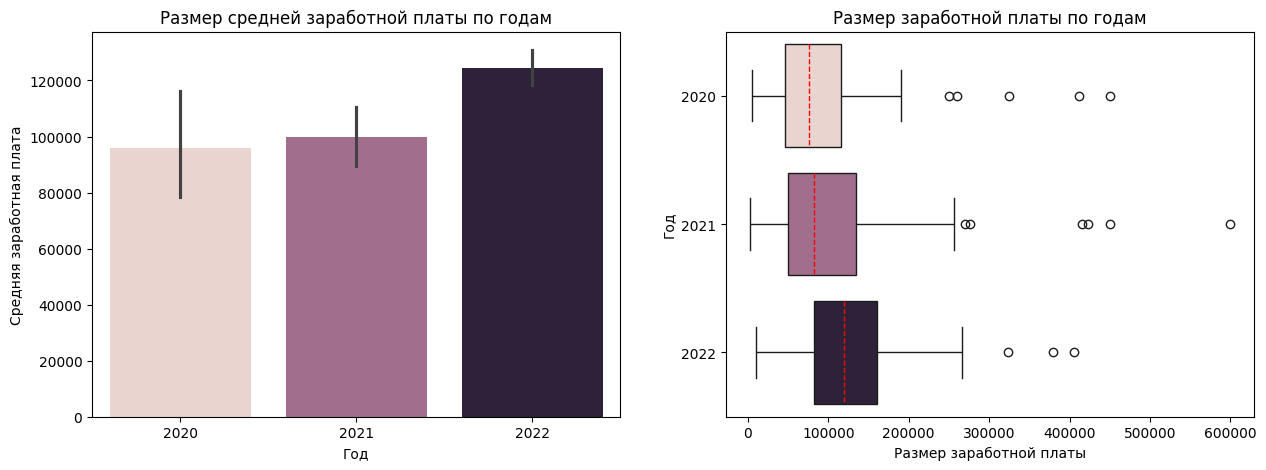

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы по годам
sns.barplot(
            data, 
            x='work_year', 
            y='salary_in_usd', 
            hue='work_year', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Год', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней заработной платы по годам')

# Строим коробчатую диаграмму для визуализации размера заработной платы по годам
sns.boxplot(
            data, 
            x='salary_in_usd', 
            y='work_year', 
            orient='h', 
            hue='work_year',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Год')
axes[1].set_title('Размер заработной платы по годам')

plt.show()

In [152]:
salary_year = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Заработная плата по годам')
salary_year

Заработная плата по годам


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,217.0,99853.79,80225.11,2859.0,50000.0,82528.0,135000.0,600000.0
2022,318.0,124522.01,58183.65,10000.0,81666.0,120000.0,160000.0,405000.0


Можно отметить, что размер средней заработной платы в 2020 и 2021 году отличается незначительно, а в 2022 году средняя заработная плата вырастает на 25%. Это может говорить об увеличении спроса на специалистов, что соответственно привело к росту уровня заработной платы. При этом, в 2022 году макисмальная заработная плата была самая низкая. Так же среди всех трех лет наблюдений в 2021 году отмечена как самая высокая так и самая низкая заработная плата.

Размер заработной платы по годам имеет различия. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

##### Размер заработной платы по годам у специалистов Data Scientist

In [153]:
# Фильтруем датасет, чтобы отобрать данные по специалистам Data Scientist
data_sc = data[data['job_title'] == 'Data Scientist']

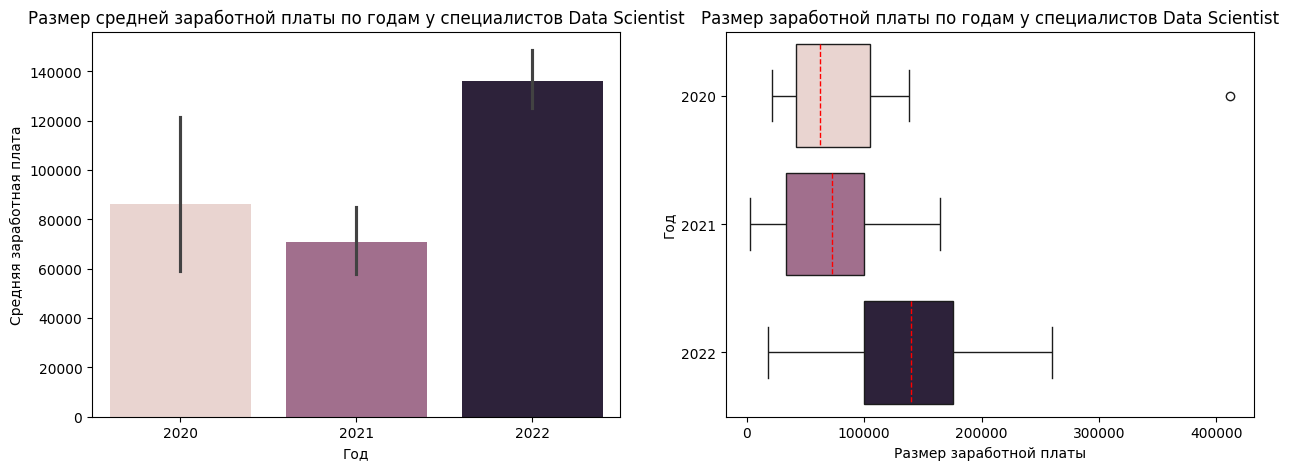

In [154]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы по годам у специалистов Data Scientist
sns.barplot(
            data_sc, 
            x='work_year', 
            y='salary_in_usd', 
            hue='work_year', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Год', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней заработной платы по годам у специалистов Data Scientist')

# Строим коробчатую диаграмму для визуализации размера заработной платы по годам у специалистов Data Scientist
sns.boxplot(
            data_sc, 
            x='salary_in_usd', 
            y='work_year', 
            orient='h', 
            hue='work_year',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Год')
axes[1].set_title('Размер заработной платы по годам у специалистов Data Scientist')

plt.show()

In [155]:
salary_year = data_sc.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Заработная плата по годам у специалистов Data Scientist')
salary_year

Заработная плата по годам у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Если рассматривать показатели заработной платы специалистов Data Scientist, то они отличаются от общих показателей. Для всех специальностей средняя заработная плата ежегодна росла, тогда как у специалистов Data Scientist в 2021 году она упала по сравнению с 2020 на 18%, а максимальная сократилась более чем в 2 раза.  Затем, в 2022 году средняя заработная плата выросла почти в 2 раза, при этом максимальная заработная плата осталась ниже уровня 2020 года. Так же можно отметить, что минимальная заработная плата среди всех специальностей отмечена у специалиста Data Scientist. 

Если в данных по заработной плате среди всех специалистов присутствуют некоторое количество выбросов, то в данных о заработной плате специалистов Data Scientist наблюдается только один выброс в 2020 году.

#### Распределение опыта работы

In [156]:
# Получаем объект Series с распределением опыта работы среди всех сотруднков
data_experience = data['experience_level'].value_counts()

In [157]:
# Получаем объект Series с распределением опыта работы среди специалистов Data Scientist
data_sc_experience = data_sc['experience_level'].value_counts()

Text(0.5, 1.0, 'Распределение опыта работы среди специалистов Data Scientist')

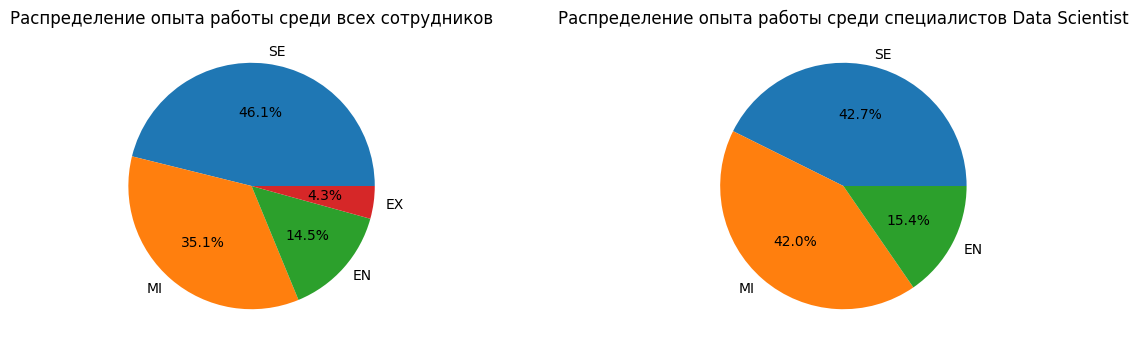

In [158]:
# Строим курговые диаграммы с рапределением опыта работы среди всех сотрудников и специалистов Data Scientist
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,4))
axes[0].pie(data_experience, labels = data_experience.index, autopct = '%.1f%%')
axes[0].set_title('Распределение опыта работы среди всех сотрудников')
axes[1].pie(data_sc_experience, labels = data_sc_experience.index, autopct = '%.1f%%')
axes[1].set_title('Распределение опыта работы среди специалистов Data Scientist')

Два наиболее часто встречающихся уровня должности в обеих выборках - Mid-level и Senior-level. Senior-level лидирует в обеих выборках. Но если в данных по всем сотрудникам разница между Mid-level и Senior-level есть и составляет 9%, то в выборке специалистов Data Scientist - оба уровня имеют одинаковый процент. На третьем месте идет уровень - Entry-level, он имеет близкий показатель в обеих выборках. Самый высокий уровень Executive-level представлен только в данных для всех специалистов и занимает всего 4%.

Можно сделать вывод, что наиболее востребованными как для всех специальностей, так и для специалистов Data Scientist являются сотрудники с опытом Mid-level и Senior-level. Уровень Entry-level занимает всего 15%, а значит конкуренция на такие места довольна высокая, как и для уровня  Executive-level. Однако можно предпродолжить, что специалистов с уровнем Executive-level в принципе намного меньше, чему с уровнем Entry-level. 

#### Соотношение заработной платы у сотрудников с разным опытом работы

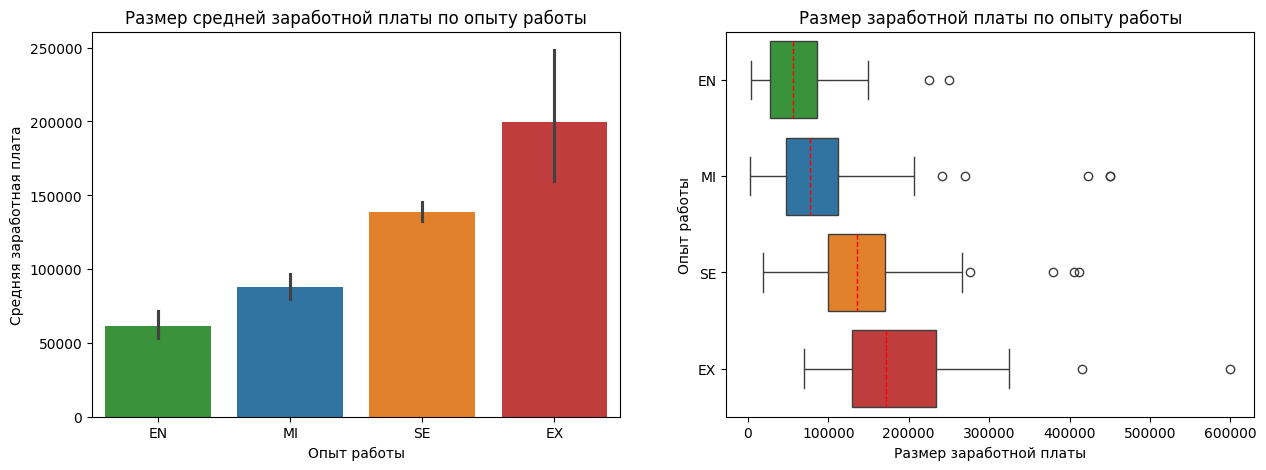

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы по опыту работы
sns.barplot(
            data, 
            x='experience_level', 
            y='salary_in_usd', 
            hue='experience_level',
            order=["EN", "MI", "SE", 'EX'],
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Опыт работы', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней заработной платы по опыту работы')

# Строим коробчатую диаграмму для визуализации размера заработной платы по опыту работы
sns.boxplot(
            data, 
            x='salary_in_usd', 
            y='experience_level', 
            orient='h', 
            hue='experience_level',
            order=["EN", "MI", "SE", 'EX'],
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Опыт работы')
axes[1].set_title('Размер заработной платы по опыту работы')

plt.show()

In [160]:
salary_experience = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Заработная плата по опыту работы')
salary_experience

Заработная плата по опыту работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.0,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.5,171437.5,233750.00,600000.0
MI,213.0,87996.06,63901.06,2859.0,48000.0,76940.0,112000.00,450000.0
SE,280.0,138617.29,57691.98,18907.0,100000.0,135500.0,170000.00,412000.0


#### Распределение заработной платы у специалистов Data Scientist с разным опытом работы

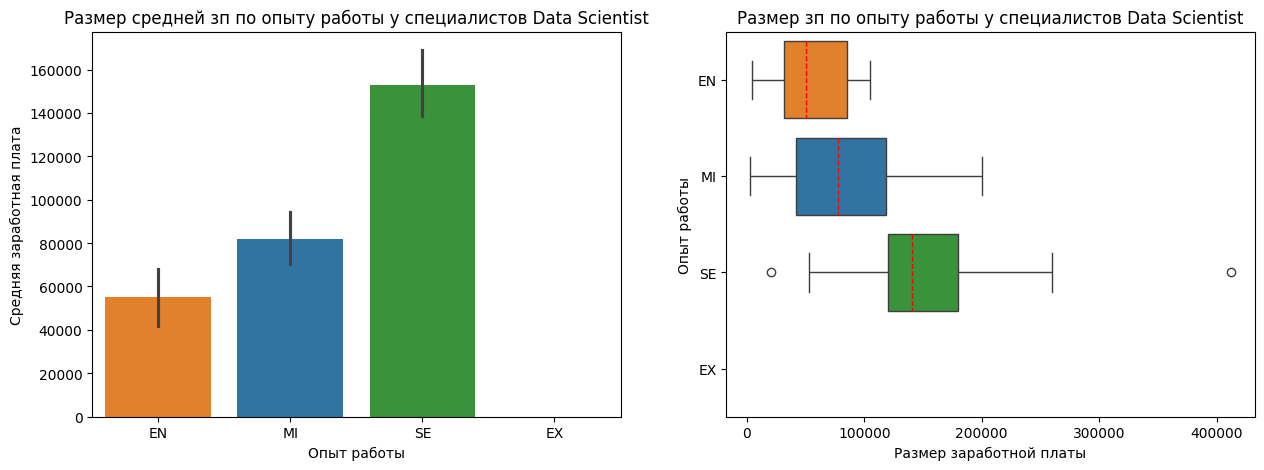

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы по опыту работы у специалистов Data Scientist
sns.barplot(
            data_sc, 
            x='experience_level', 
            y='salary_in_usd', 
            hue='experience_level',
            order=["EN", "MI", "SE", 'EX'],
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Опыт работы', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней зп по опыту работы у специалистов Data Scientist')

# Строим коробчатую диаграмму для визуализации размера заработной платы по опыту работы у специалистов Data Scientist
sns.boxplot(
            data_sc, 
            x='salary_in_usd', 
            y='experience_level', 
            orient='h', 
            hue='experience_level',
            order=["EN", "MI", "SE", 'EX'],
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Опыт работы')
axes[1].set_title('Размер зп по опыту работы у специалистов Data Scientist')

plt.show()

In [162]:
salary_experience_ds = data_sc.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Заработная плата по опыту работы у специалистов Data Scientist')
salary_experience_ds

Заработная плата по опыту работы у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


Анализ сооношения заработной платы и опыта работы показал, что, чем больше опыт работы, тем выше заработная плата.

Если в данных по всем сотрудникам заработная плата растет постепенно с увеличением опыта работы, то у специалистов Data Scientist наблюдается резкий скачок уровня заработной платы между специалистами уровня Mid-level и Senior-level. По всем статистическим показателям разница в заработных платах этих двух уровней составляет 2 и более раз. Можно предположить, что специалисты Senior-level относятся к категории руководителей, соответственно к ним предъявляются более высокие требования, они решают более сложные и серьезные задачи, соответственно их работа оплачивается более высоко.

Если в данных по заработной плате среди всех специалистов присутствуют некоторое количество выбросов, то в данных о заработной плате специалистов Data Scientist наблюдается выбросы только для Senior-level.

#### Распределение типов трудоустройства

In [163]:
# Получаем объект Series с распределением типов трудоуйстройства среди всех сотруднков
data_employment = data['employment_type'].value_counts()

In [164]:
# Получаем объект Series с распределением типов трудоуйстройства среди специалистов Data Scientist
data_sc_employment = data_sc['employment_type'].value_counts()

Text(0.5, 1.0, 'Типы трудоустройства среди специалистов Data Scientist')

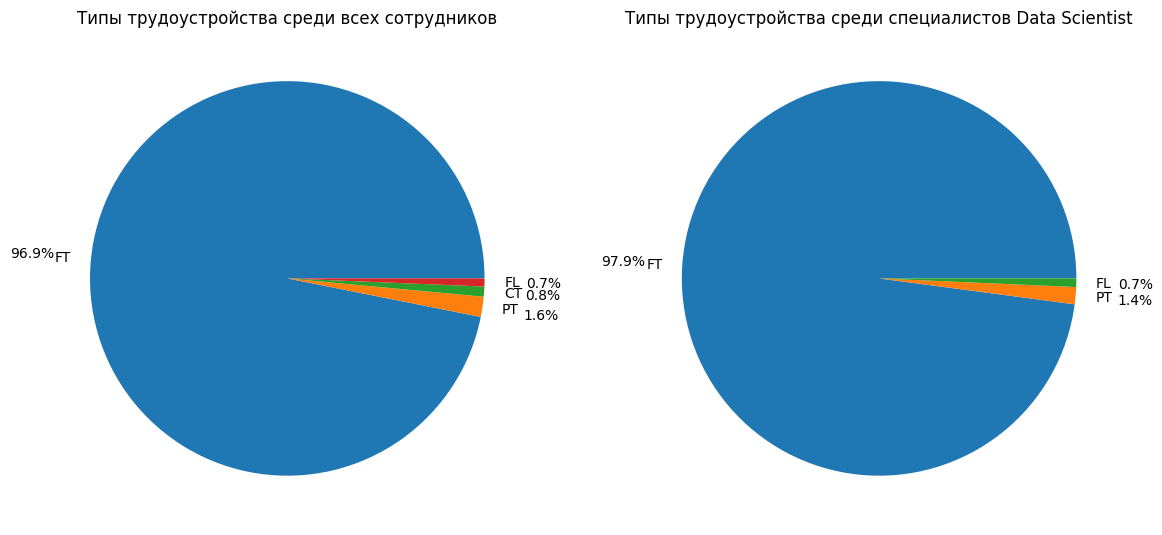

In [165]:
# Строим курговые диаграммы с рапределением типов трудоуйстройства среди всех сотрудников и специалистов Data Scientist
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,8))
axes[0].pie(data_employment, labels = data_employment.index, autopct = '%.1f%%', pctdistance=1.3)
axes[0].set_title('Типы трудоустройства среди всех сотрудников')
axes[1].pie(data_sc_employment, labels = data_sc_employment.index, autopct = '%.1f%%', pctdistance=1.3)
axes[1].set_title('Типы трудоустройства среди специалистов Data Scientist')

Подавляющее большинство типов трудоустройств для обеих выборок относится к полному рабочему дню (FT). Значения остальных типов трудоустройств - неполный рабочий день(PT), контракт(CT) и фриланс(FL) - незначительны. 

#### Соотношение заработной платы у сотрудников с разным типом трудоустройства.

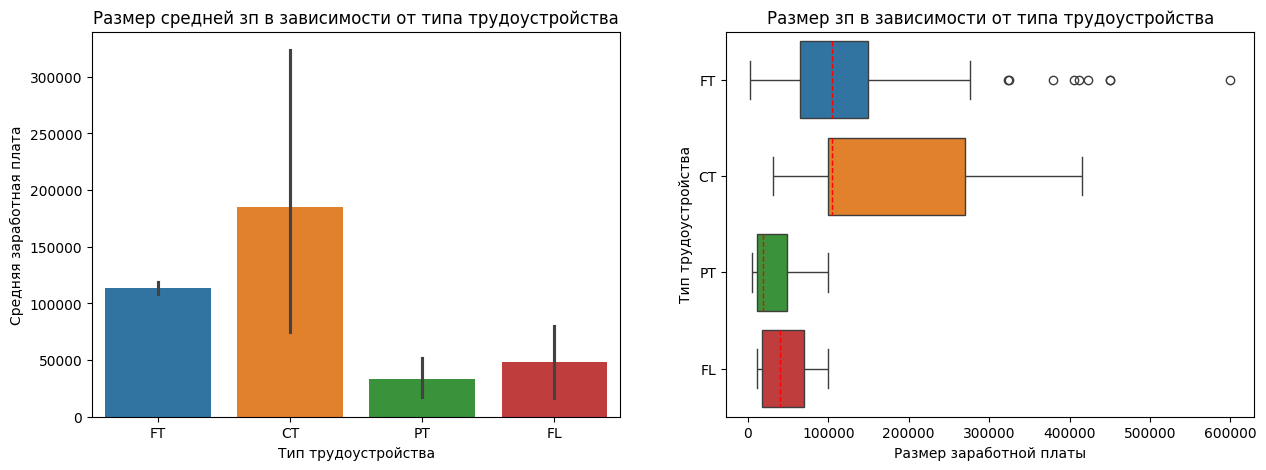

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от типа трудоустройства
sns.barplot(
            data, 
            x='employment_type', 
            y='salary_in_usd', 
            hue='employment_type', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип трудоустройства', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней зп в зависимости от типа трудоустройства')

# Строим коробчатую диаграмму для визуализации размера заработной платы в зависимости от типа трудоустройства
sns.boxplot(
            data, 
            x='salary_in_usd', 
            y='employment_type', 
            orient='h', 
            hue='employment_type',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Тип трудоустройства')
axes[1].set_title('Размер зп в зависимости от типа трудоустройства')

plt.show()

In [168]:
salary_employment = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от типа трудоустройства')
salary_employment

Заработная плата в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.00,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.00,40000.0,70000.0,100000.0
FT,588.0,113468.07,69476.47,2859.0,64962.25,104196.5,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.00,18817.5,48370.0,100000.0


Размер заработной платы зависит от типа трудоустройства. 

Наименее оплачиваемые сотрудники на неполном рабочем дне или фрилансе. Их заработная плата в разы ниже, чем у сотрудников на полном рабочем дне и контракте. Самая высокая заработная плата у сотрудников на контракте, однако их совсем не много в общей массе - всего 5. Меньше только фрилансеров - 4. 

Данные по сотрудникам на полном рабочем дне имеют выбросы, что может сказываться на статистичесих характеристиках данного типа трудоустройства. В других категориях типов трудоустройств выбросов не наблюдается, скорее всего это связано с малым количеством данных в этих категориях.

#### Соотношение заработной платы у специалистов Data Scientist с разным типом трудоустройства

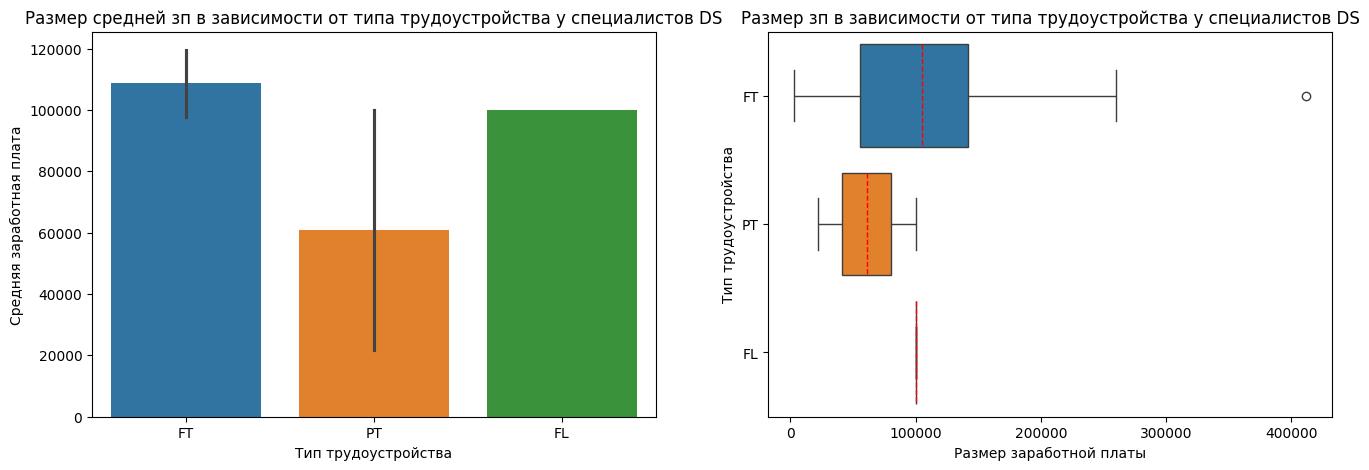

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от типа трудоустройства у специалистов Data Scientist
sns.barplot(
            data_sc, 
            x='employment_type', 
            y='salary_in_usd', 
            hue='employment_type', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип трудоустройства', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней зп в зависимости от типа трудоустройства у специалистов DS')

# Строим коробчатую диаграмму для визуализации размера заработной платы в зависимости от типа трудоустройства у специалистов Data Scientist
sns.boxplot(
            data_sc, 
            x='salary_in_usd', 
            y='employment_type', 
            orient='h', 
            hue='employment_type',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Тип трудоустройства')
axes[1].set_title('Размер зп в зависимости от типа трудоустройства у специалистов DS')

plt.show()

In [170]:
salary_experience_ds = data_sc.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от типа трудоустройства у специалистов Data Scientist')
salary_experience_ds

Заработная плата в зависимости от типа трудоустройства у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,140.0,108922.79,64372.43,2859.0,55490.00,104796.0,141975.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


Более высокая заработная плата у специалистов DS с типом занятости полный рабочий день и фриланс. Однако по фрилансу есть только 1 запись, соответственно это может искажать полученные результаты. У специалистов DS с неполным рабочим днем заработная плата существенно (в 2 и более раз) ниже, чем у первых двух категорий.


#### Распределение ролей

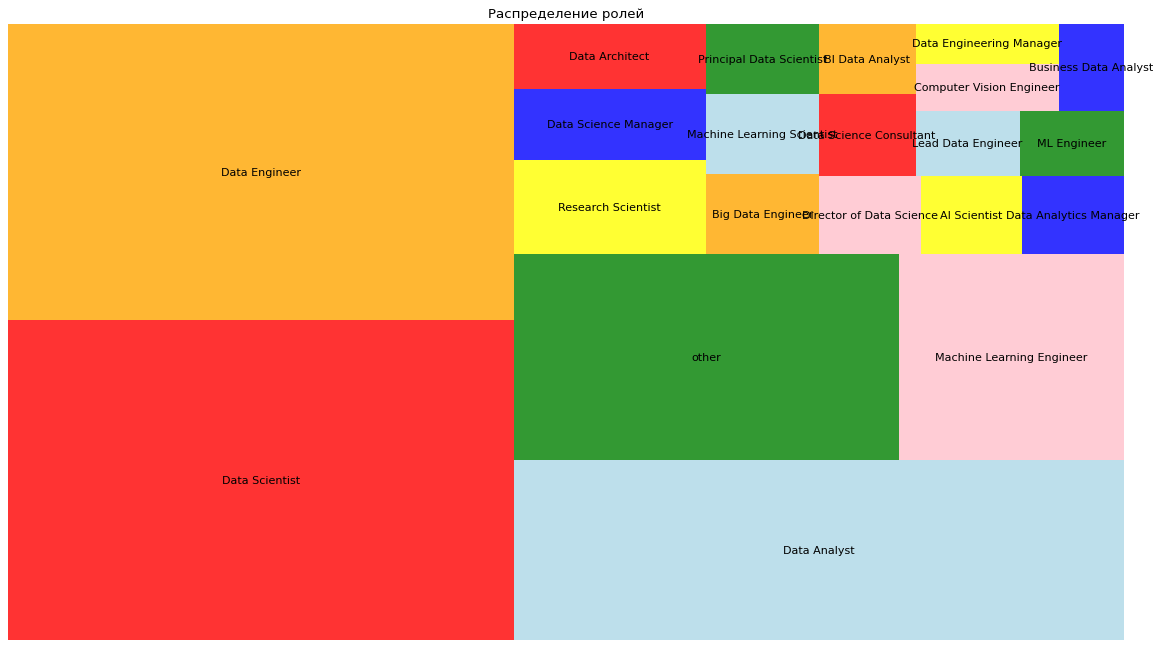

In [171]:
# Преобразуем данные о ролях соискателей и их количестве в объект Series. Оставляем 20 наиболее популярных ролей, остальные объединяем в "other"
data_jt = data.copy()
popular_jt = data_jt['job_title'].value_counts().nlargest(20).index
data_jt['job_title_new'] = data_jt['job_title'].apply(lambda x: x if x in popular_jt else 'other')
data_jt = data_jt.groupby('job_title_new')['job_title_new'].value_counts()
data_jt = data_jt.sort_values(ascending=False)

# строим древовидную диаграмму с рапределением ролей
plt.figure(figsize=(18,10), dpi= 80)
squarify.plot(sizes = data_jt.values, label = data_jt.index, alpha=.8, color = ['red','orange','lightblue','green','pink','yellow', 'blue'])

plt.title('Распределение ролей')
plt.axis('off')
plt.show()

Специалисты Data Engineer, Data Scientist, Data Analyst занимают большую часть среди всех представленных профессий. Доля первых двух составляет почти 50%.

#### Распределение заработной платы среди всех сотрудников в зависимости от роли.

In [172]:

# Преобразуем данные для построения столбчатой и коробчатой диаграмм. Оставляем 20 наиболее популярных ролей, остальные объединяем в "other"
data_jt_sns = data.copy()
popular_jt = data_jt_sns['job_title'].value_counts().nlargest(20).index
data_jt_sns['job_title_new'] = data_jt_sns['job_title'].apply(lambda x: x if x in popular_jt else 'other')
data_jt_sns_new = pd.DataFrame(data_jt_sns.groupby('job_title_new')['salary_in_usd'].mean().sort_values(ascending = False))

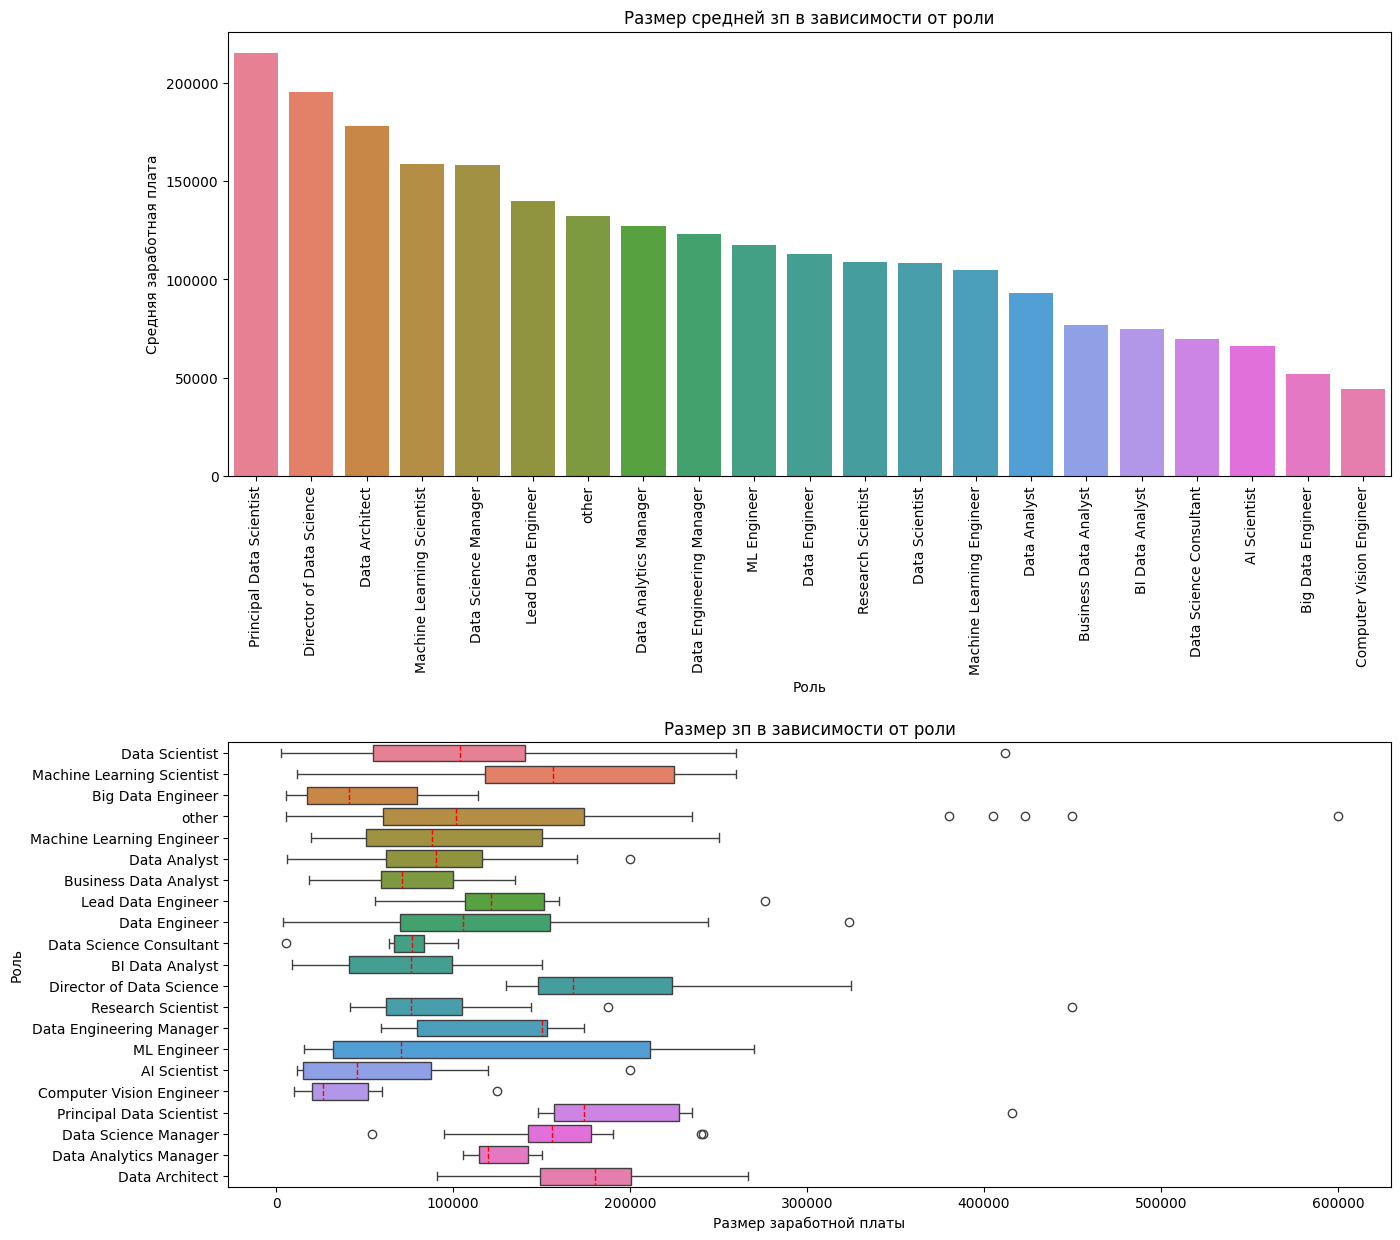

In [173]:
fig, axes = plt.subplots(2, 1, figsize=(15, 15))
plt.subplots_adjust(hspace=0.6)

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от роли
sns.barplot(
            data_jt_sns_new, 
            x='job_title_new', 
            y='salary_in_usd', 
            hue='job_title_new',
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Роль', ylabel='Средняя заработная плата')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Размер средней зп в зависимости от роли')

# Строим коробчатую диаграмму для визуализации размера заработной платы в зависимости от роли
sns.boxplot(
            data_jt_sns, 
            x='salary_in_usd', 
            y='job_title_new', 
            orient='h', 
            hue='job_title_new',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Роль')
axes[1].set_title('Размер зп в зависимости от роли')

plt.show()

In [174]:
salary_data_jt_sns = data_jt_sns.groupby('job_title_new')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от роли')
salary_data_jt_sns

Заработная плата в зависимости от роли


,count,mean,std,min,25%,50%,75%,max
job_title_new,,,,,,,,
AI Scientist,7.0,66135.57,70152.16,12000.0,15026.50,45896.0,87500.00,200000.0
BI Data Analyst,6.0,74755.17,50989.56,9272.0,40944.25,76500.0,99500.00,150000.0
Big Data Engineer,8.0,51974.00,42954.76,5882.0,17557.00,41305.5,79756.00,114047.0
Business Data Analyst,5.0,76691.20,43814.85,18442.0,59102.00,70912.0,100000.00,135000.0
Computer Vision Engineer,6.0,44419.33,42984.85,10000.0,20180.25,26304.5,52152.25,125000.0
Data Analyst,97.0,92893.06,39961.08,6072.0,62000.00,90320.0,116150.00,200000.0
Data Analytics Manager,7.0,127134.29,17853.38,105400.0,114640.00,120000.0,142500.00,150260.0
Data Architect,11.0,177873.91,45714.72,90700.0,148900.00,180000.0,200669.50,266400.0
Data Engineer,132.0,112725.00,57629.08,4000.0,70039.50,105500.0,154600.00,324000.0


Роль сотрудника влияет на размер его заработной платы. 

Роли Manager, Principal, Director, Lead - наиболее высокооплачиваемые. Что касается трех наиболее популярных ролей - Data Scientist, Data Engineer, Data Analyst - разница между заработной платы первых двух незначительна, оплата Data Analyst отстает на 20-30%. Так же Data Scientist, Data Engineer имеют один из самых высоких показателей макисмальной заработной платы, наравне со специалистами Manager, Principal, Director, Lead. 

Big Data Engineer, Data Science Consultant, Computer Vision Engineer имеют самые низкие показатели уровня заработной платы из представленных 20 наиболее популярных ролей.

#### Распределение заработной платы среди всех сотрудников

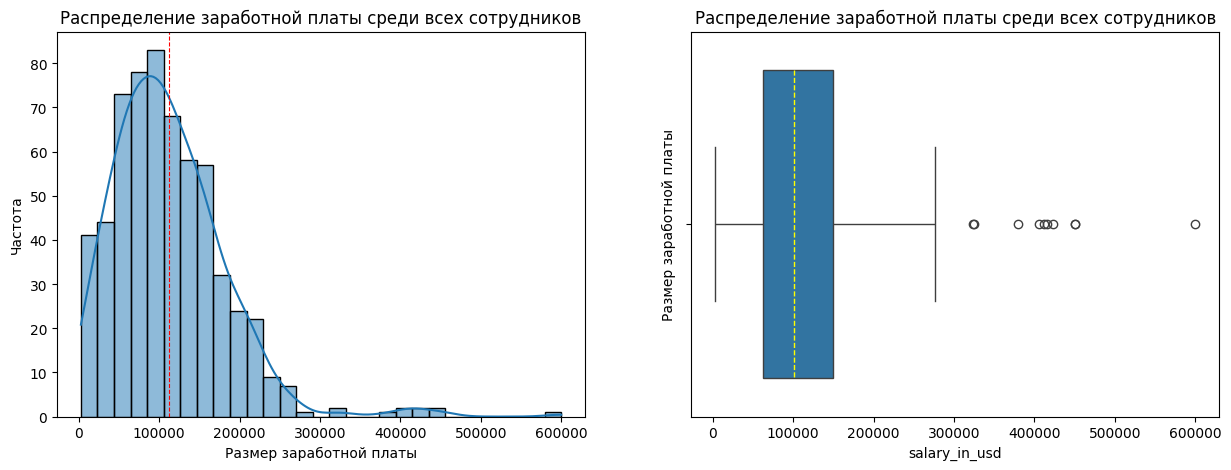

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим гистограмму, показывающую распределение заработной платы
sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы', ylabel='Частота')
axes[0].set_title('Распределение заработной платы среди всех сотрудников')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

# Строим коробчатую, показывающую распределение заработной платы
sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "yellow", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы среди всех сотрудников')

plt.show()

In [176]:
salary_data = data['salary_in_usd'].describe().round(2)
print('Заработная плата среди всех сотрудников')
salary_data

Заработная плата среди всех сотрудников


count       607.00
mean     112297.87
std       70957.26
min        2859.00
25%       62726.00
50%      101570.00
75%      150000.00
max      600000.00
Name: salary_in_usd, dtype: float64

 Распределение заработной платы отлично от нормального, имеются выбросы. Наибольшее количество размеров заработных плат находится в интервале между 62000 и 150000. Заработные платы в размере от 300000 могут быть выбросами. В среднем специалист DS может рассчитывать на заработную плату в районе 100000.

#### Распределение заработной платы среди специалистов Data Scientist

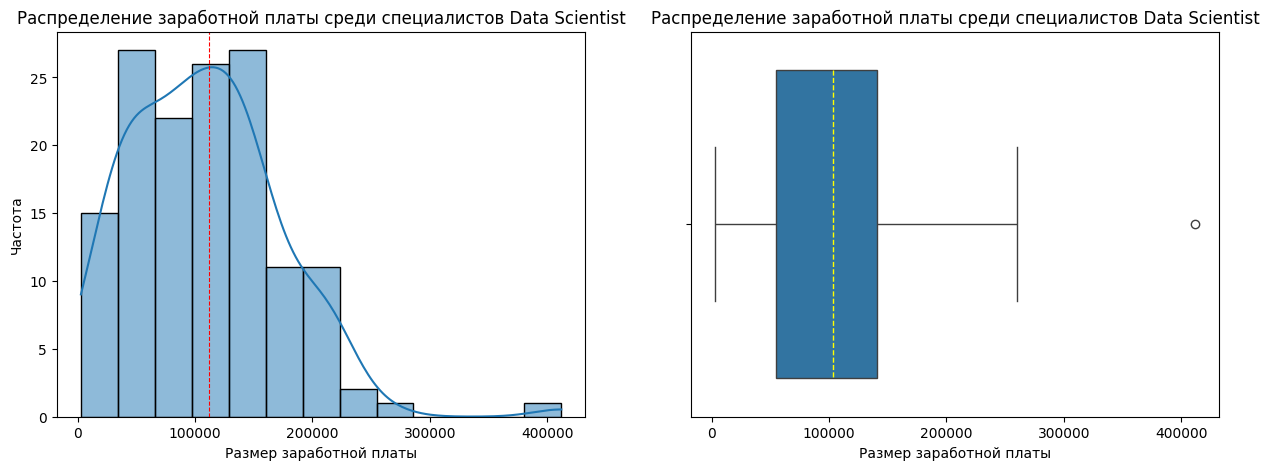

In [177]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим гистограмму, показывающую распределение заработной платы среди специалистов Data Scientist
sns.histplot(data_sc['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы', ylabel='Частота')
axes[0].set_title('Распределение заработной платы среди специалистов Data Scientist')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

# Строим коробчатую, показывающую распределение заработной платы среди специалистов Data Scientist
sns.boxplot(data_sc['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "yellow", "linestyle": '--'})
axes[1].set(xlabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы среди специалистов Data Scientist')

plt.show()

In [178]:
salary_data_ds = data_sc['salary_in_usd'].describe().round(2)
print('Заработная плата среди специалистов Data Scientist')
salary_data_ds

Заработная плата среди специалистов Data Scientist


count       143.00
mean     108187.83
std       64112.84
min        2859.00
25%       54724.00
50%      103691.00
75%      140850.00
max      412000.00
Name: salary_in_usd, dtype: float64

Распределение заработной платы отлично от нормального, имеется выброс. Наибольшее количество размеров заработных плат специалистов DS находится в интервале между 54000 и 140000. Макисмальная заработная плата в 412000 - является выбросом. В среднем специалист DS может рассчитывать на заработную плату в районе 100000.

#### Распределение заработной платы среди специалистов Data Scientist и Data Engineer в 2022 году

In [179]:
# Фильтруем датасет, чтобы отобрать данные по специалистам Data Engineer
data_en = data[data['job_title'] == 'Data Engineer']

In [180]:
# Объединяем таблицу  Data Scientist с Data Engineer
data_sc_en = pd.concat([data_sc, data_en], ignore_index = True)

In [181]:
# Фильтруем датасет, чтобы отобрать данные по 2022 году
data_sc_en_2022 = data_sc_en[data_sc_en['work_year']==2022]

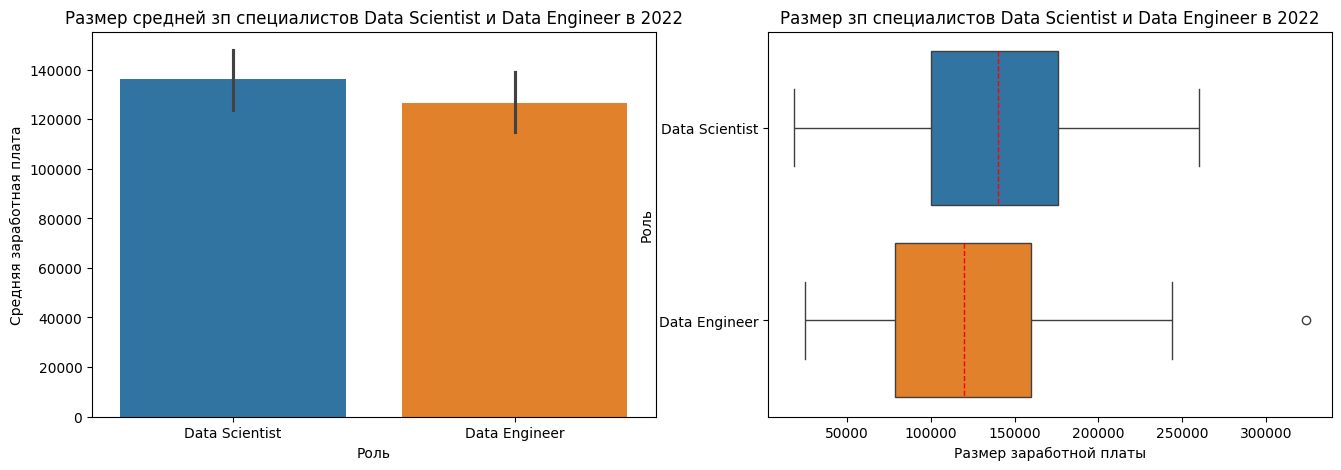

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы специалистов Data Scientist и Data Engineer в 2022
sns.barplot(
            data_sc_en_2022, 
            x='job_title', 
            y='salary_in_usd', 
            hue='job_title', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Роль', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней зп специалистов Data Scientist и Data Engineer в 2022')

# Строим коробчатую диаграмму для визуализации размера заработной платы у специалистов Data Scientist и Data Engineer в 2022
sns.boxplot(
            data_sc_en_2022, 
            x='salary_in_usd', 
            y='job_title', 
            orient='h', 
            hue='job_title',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Роль')
axes[1].set_title('Размер зп специалистов Data Scientist и Data Engineer в 2022')

plt.show()

In [183]:
salary_data_2022 = data_sc_en_2022.groupby('job_title')['salary_in_usd'].describe().round(2)
print('Заработная плата специалистов Data Scientist и Data Engineer в 2022')
salary_data_2022

Заработная плата специалистов Data Scientist и Data Engineer в 2022


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,89.0,126375.70,55954.40,25000.0,78526.0,120000.0,160000.0,324000.0
Data Scientist,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Показатели заработной платы в 2022 году у Data Engineer чуть ниже, чем у Data Scientist.

#### Распределение стран проживания среди всех сотрудников.

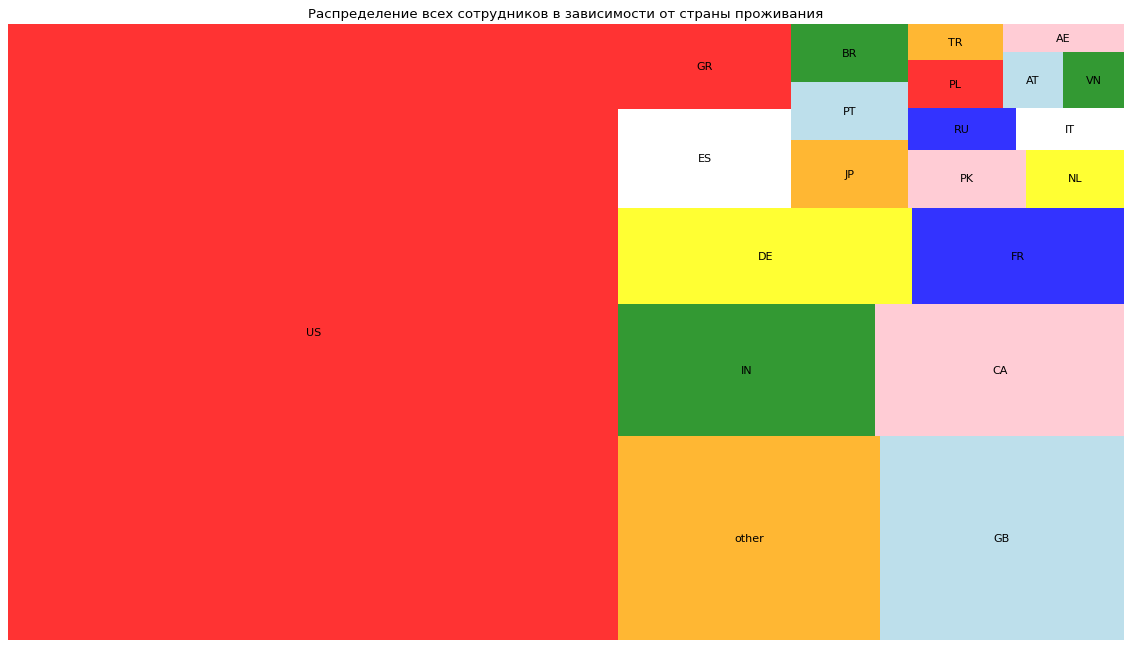

In [184]:
# Преобразуем данные о странах проживания сотрудников и их количестве в объект Series. Оставляем 20 наиболее популярных стран, остальные объединяем в "other"
data_er = data.copy()
popular_residence = data_er['employee_residence'].value_counts().nlargest(20).index
data_er['employee_residence_new'] = data_er['employee_residence'].apply(lambda x: x if x in popular_residence else 'other')
data_er = data_er.groupby('employee_residence_new')['employee_residence_new'].value_counts()
data_er = data_er.sort_values(ascending=False)

# строим древовидную диаграмму с рапределением стран проживания сотрудников
plt.figure(figsize=(18,10), dpi= 80)
squarify.plot(sizes = data_er.values, label = data_er.index, alpha=.8, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Распределение всех сотрудников в зависимости от страны проживания')
plt.axis('off')
plt.show()

В представленных данных более половины всех сотрудников проживают в США. Возможно это связано с нахождением в США Кремниевой Долины, которая отличается большой плотностью высокотехнологичных компаний, связанных с разработкой и производством компьютеров и их составляющих, особенно микропроцессоров, а также программного обеспечения, устройств мобильной связи, биотехнологии и т. п. 

Также значительным количеством сотрудников представлены Великобритания, Индия, Канада, Германия, Франция, Испания и Греция. Большинство этих стран раположено в Европе, которая также нацелена на разработку и совершенствование программного обеспечения. 

Специалисты из Индии также занимают значительную долю сотрудников, возможно это связано с их требованием более низкой заработной платы, чему у американцев и европейцев. Кроме того, их большое количество говорит о том, что если в команде руководитель и специалисты уже индийцы, то им проще взять тоже индийца для лучшей коммуникации.

#### Распределение стран проживания среди специалистов DS.

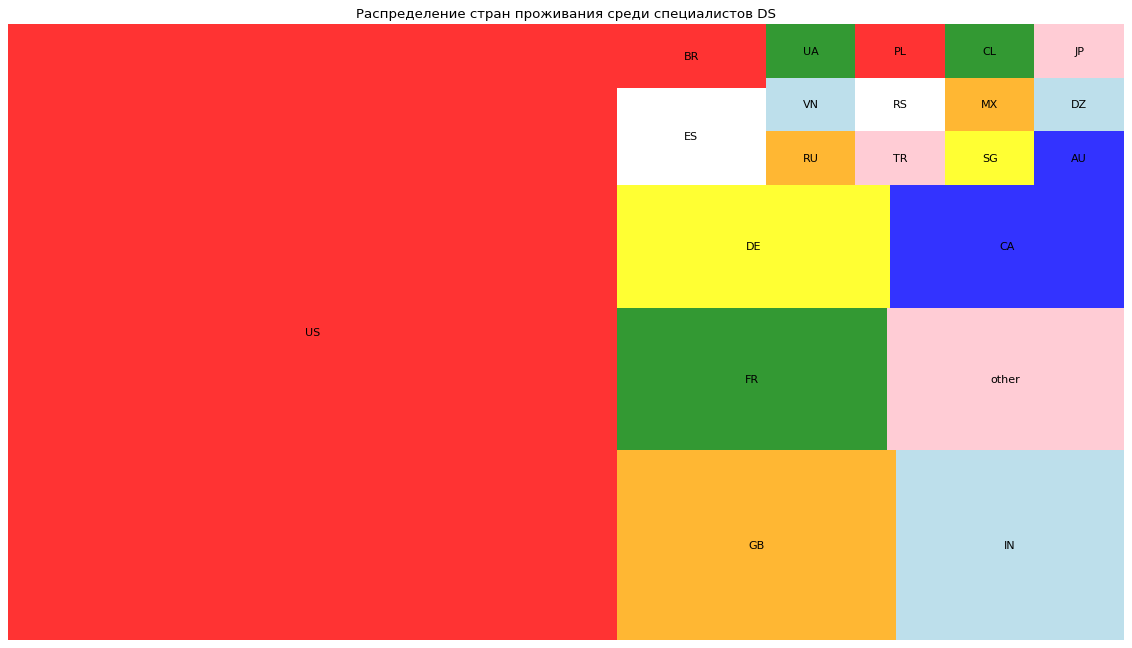

In [185]:
# Преобразуем данные о странах проживания специалистов DS и их количестве в объект Series. Оставляем 20 наиболее популярных стран, остальные объединяем в "other"
data_sc_er = data_sc.copy()
popular_residence_sc = data_sc_er['employee_residence'].value_counts().nlargest(20).index
data_sc_er['employee_residence_new'] = data_sc_er['employee_residence'].apply(lambda x: x if x in popular_residence_sc else 'other')
data_sc_er = data_sc_er.groupby('employee_residence_new')['employee_residence_new'].value_counts()
data_sc_er = data_sc_er.sort_values(ascending=False)

# строим древовидную диаграмму с рапределением стран проживания среди специалистов DS
plt.figure(figsize=(18,10), dpi= 80)
squarify.plot(sizes = data_sc_er.values, label = data_sc_er.index, alpha=.8, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Распределение стран проживания среди специалистов DS')
plt.axis('off')
plt.show()

Данные по странам проживания специалистов DS схожи с данными по странам проживания среди всех сотрудников. Также более половины специалистов DS проживают в США, а также значительная часть - в Великобритании, Индии, Франции, Германии, Канаде и Испании.

#### Распределение заработной платы в зависимости от страны проживания.

In [186]:
# Преобразуем данные о странах проживания сотрудников и их количестве. Оставляем 10 наиболее популярных стран, остальные объединяем в "other", сортируем по убыванию средней зп
data_er_sns = data.copy()
popular_residence_sns = data_er_sns['employee_residence'].value_counts().nlargest(10).index
data_er_sns['employee_residence_new'] = data_er_sns['employee_residence'].apply(lambda x: x if x in popular_residence_sns else 'other')
data_er_sns_new = pd.DataFrame(data_er_sns.groupby('employee_residence_new')['salary_in_usd'].mean().sort_values(ascending = False))

In [187]:
# Преобразуем данные о странах проживания специалистов DS и их количестве. Оставляем 10 наиболее популярных стран, остальные объединяем в "other"
data_sc_er_sns = data_sc.copy()
popular_residence_sc_sns = data_sc_er_sns['employee_residence'].value_counts().nlargest(10).index
data_sc_er_sns['employee_residence_new'] = data_sc_er_sns['employee_residence'].apply(lambda x: x if x in popular_residence_sc_sns else 'other')
data_sc_er_sns_new = pd.DataFrame(data_sc_er_sns.groupby('employee_residence_new')['salary_in_usd'].mean().sort_values(ascending = False))

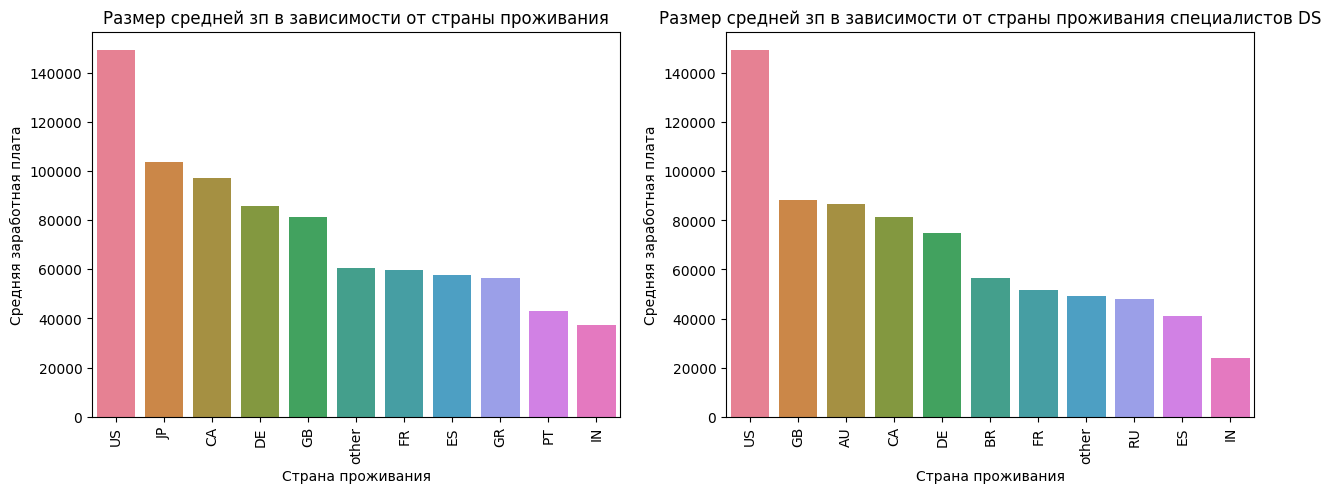

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от страны проживания
sns.barplot(
            data_er_sns_new, 
            x='employee_residence_new', 
            y='salary_in_usd', 
            hue='employee_residence_new',
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Страна проживания', ylabel='Средняя заработная плата')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Размер средней зп в зависимости от страны проживания')

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от страны проживания специалистов DS
sns.barplot(
            data_sc_er_sns_new, 
            x='employee_residence_new', 
            y='salary_in_usd', 
            hue='employee_residence_new',
            legend=False, 
            ax=axes[1]
            )
axes[1].set(xlabel='Страна проживания', ylabel='Средняя заработная плата')
axes[1].xaxis.set_tick_params(rotation = 90)
axes[1].set_title('Размер средней зп в зависимости от страны проживания специалистов DS')

plt.show()

In [189]:
salary_data_er_sns = data_er_sns.groupby('employee_residence_new')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от страны проживания')
salary_data_er_sns

Заработная плата в зависимости от страны проживания


,count,mean,std,min,25%,50%,75%,max
employee_residence_new,,,,,,,,
CA,29.0,97085.31,39767.44,52000.0,70912.00,85000.0,117104.00,196979.0
DE,25.0,85552.56,39383.70,15966.0,62726.00,79197.0,94564.00,173762.0
ES,15.0,57593.40,28395.03,10354.0,41371.00,49461.0,71444.50,130800.0
FR,18.0,59886.61,15848.69,36643.0,49734.50,57920.0,69342.50,93427.0
GB,44.0,81403.16,29932.84,37300.0,55751.50,78526.0,103545.50,183228.0
GR,13.0,56331.23,20631.68,20000.0,43966.00,54957.0,68428.00,88654.0
IN,30.0,37322.33,43741.19,5409.0,16397.00,22124.0,38812.75,200000.0
JP,7.0,103537.71,81283.30,40000.0,52700.00,74000.0,122682.00,260000.0
PT,6.0,42862.50,21443.78,10000.0,29032.25,53090.0,57691.25,60757.0


In [190]:
salary_data_sc_er_sns = data_sc_er_sns.groupby('employee_residence_new')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от страны проживания сотрудников DS')
salary_data_sc_er_sns

Заработная плата в зависимости от страны проживания сотрудников DS


,count,mean,std,min,25%,50%,75%,max
employee_residence_new,,,,,,,,
AU,1.0,86703.00,NaN,86703.0,86703.00,86703.0,86703.00,86703.0
BR,2.0,56450.50,61588.29,12901.0,34675.75,56450.5,78225.25,100000.0
CA,6.0,81489.17,19500.74,52396.0,70945.50,81756.0,96934.50,103691.0
DE,7.0,74773.71,16834.87,49268.0,62096.50,79833.0,89694.00,90734.0
ES,3.0,41136.67,4935.34,37825.0,38300.50,38776.0,42792.50,46809.0
FR,8.0,51665.62,13412.16,36643.0,41626.75,50483.5,55575.50,77684.0
GB,11.0,88177.36,41393.50,39263.0,60847.00,76958.0,110808.00,183228.0
IN,9.0,23838.33,11758.72,5679.0,16904.00,28399.0,31615.00,40481.0
RU,1.0,48000.00,NaN,48000.0,48000.00,48000.0,48000.00,48000.0


Страна проживания сотрудника влияет на уровень его заработной платы.

Самая высокие показатели  заработной платы как среди всех сотрудников так и для специалистов DS в США. Но если в выборке среди всех сотрудников разница между средней заработной платой в США и следующей за ней Японией около 40%, то у специалистов DS средняя заработная плата в США и следующей за ней Великобританией различается более чем на 60%. 

Что касается максимальной заработной платы, то здесь сотрудники из США могут рассчитывать на заработную плату в 2 и более раз выше, чем сотрудники из других стран.

Как и предполагалось ранее - самая низкие показатели заработной платы у сотрудников из Индии.

#### Распределение объема работы выполняемой удаленно

In [191]:
# Получаем объект Series с распределением объема работы, выполняемой удаленно среди всех сотруднков
data_rr = data['remote_ratio'].value_counts()

In [192]:
# Получаем объект Series с распределением объема работы, выполняемой удаленно среди специалистов Data Scientist
data_cs_rr = data_sc['remote_ratio'].value_counts()

Text(0.5, 1.0, 'Распределение объема работы, \n выполняемой удаленно, среди специалистов DS')

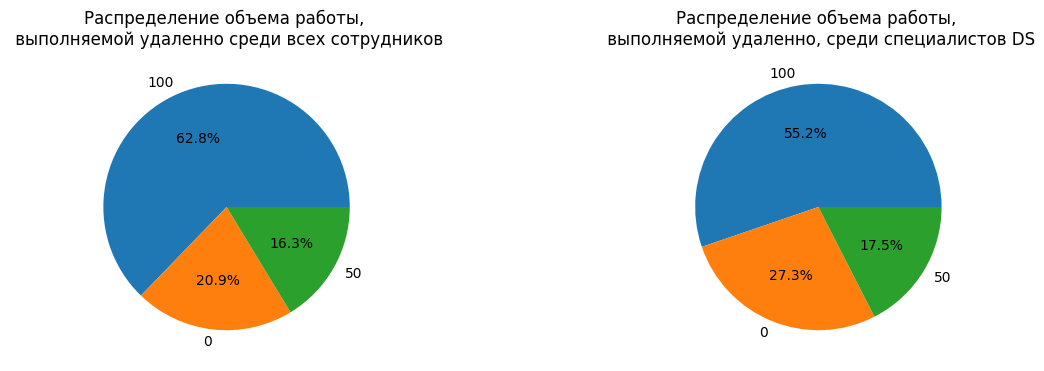

In [193]:
# Строим курговые диаграммы с рапределением объема работы, выполняемой удаленно, среди всех сотрудников и специалистов Data Scientist
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,4))
axes[0].pie(data_rr, labels = data_rr.index, autopct = '%.1f%%')
axes[0].set_title('Распределение объема работы, \n выполняемой удаленно среди всех сотрудников')
axes[1].pie(data_cs_rr, labels = data_cs_rr.index, autopct = '%.1f%%')
axes[1].set_title('Распределение объема работы, \n выполняемой удаленно, среди специалистов DS')

В обеих выборках данных схожие показатели. На полностью удаленной работе занято большее количество сотрудников среди всех(62,8%) и среди специалистов DS(55.2%). Меньше всего сотрудников работают частично удаленно: 16.3% - среди всех, 17.5% - среди специалистов DS.

#### Соотношение заработной платы у сотрудников с разным объемом работы, выполняемой удаленно.

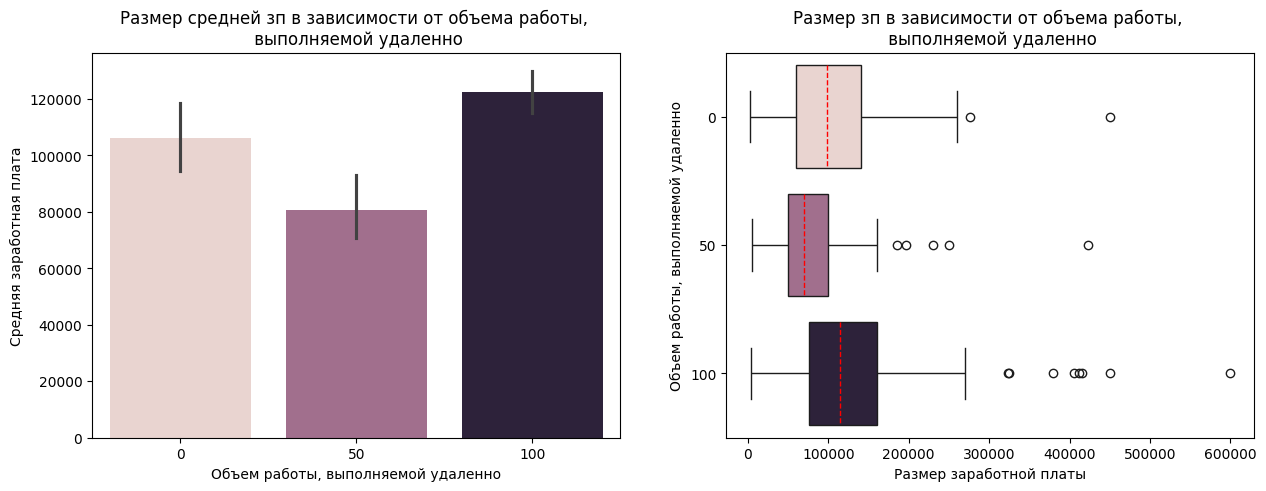

In [194]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от объема работы, выполняемой удаленно
sns.barplot(
            data, 
            x='remote_ratio', 
            y='salary_in_usd', 
            hue='remote_ratio', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Объем работы, выполняемой удаленно', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней зп в зависимости от объема работы, \n выполняемой удаленно')

# Строим коробчатую диаграмму для визуализации размера заработной платы в зависимости от объема работы, выполняемой удаленно
sns.boxplot(
            data, 
            x='salary_in_usd', 
            y='remote_ratio', 
            orient='h', 
            hue='remote_ratio',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Объем работы, выполняемой удаленно')
axes[1].set_title('Размер зп в зависимости от объема работы, \n выполняемой удаленно')

plt.show()

In [242]:
salary_rr = data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от объема работы, выполняемой удаленно')
salary_rr

Заработная плата в зависимости от объема работы, выполняемой удаленно


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,127.0,106354.62,67724.54,2859.0,60000.0,99000.0,140400.0,450000.0
50,99.0,80823.03,57353.09,5409.0,50355.0,69999.0,99851.5,423000.0
100,381.0,122457.45,72710.84,4000.0,75774.0,115000.0,160000.0,600000.0


Заработная плата зависит от объема работы, выполняемой удаленно, но не так сильно, как от других показателей. Особенно невелика разница между показателями заработной платы у сотрудников на полностью удаленной и тех, у кого нет удаленной работы. Сотрудники с частично удаленной работой являются самой низкооплачиваемой категорией.

#### Соотношение заработной платы у специалистов DS с разным объемом работы, выполняемой удаленно.

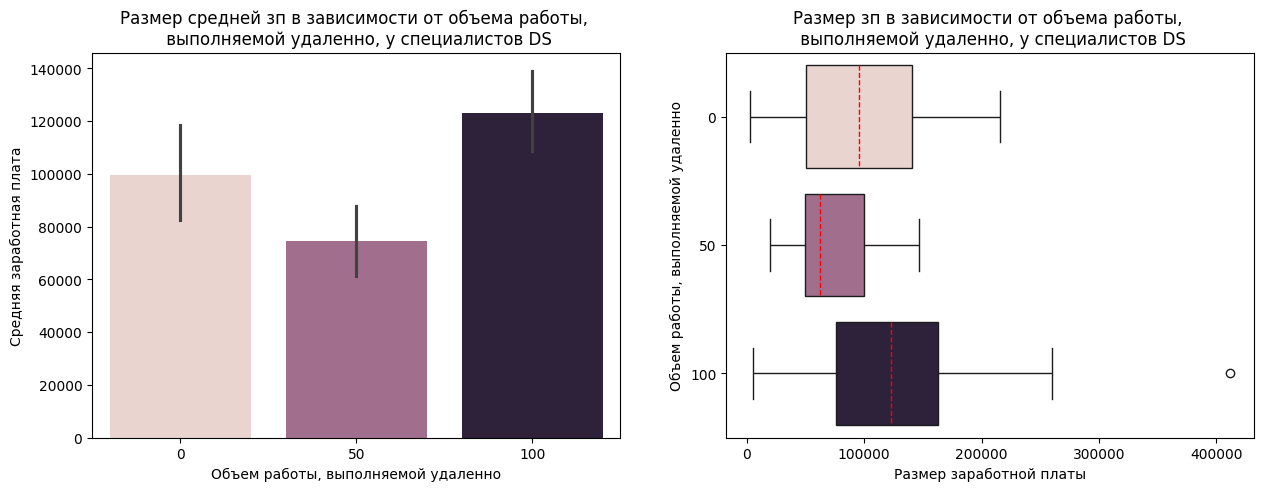

In [196]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от объема работы, выполняемой удаленно, у специалистов DS
sns.barplot(
            data_sc, 
            x='remote_ratio', 
            y='salary_in_usd', 
            hue='remote_ratio', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Объем работы, выполняемой удаленно', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней зп в зависимости от объема работы, \n выполняемой удаленно, у специалистов DS')

# Строим коробчатую диаграмму для визуализации размера заработной платы в зависимости от объема работы, выполняемой удаленно, у специалистов DS
sns.boxplot(
            data_sc, 
            x='salary_in_usd', 
            y='remote_ratio', 
            orient='h', 
            hue='remote_ratio',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Объем работы, выполняемой удаленно')
axes[1].set_title('Размер зп в зависимости от объема работы, \n выполняемой удаленно, у специалистов DS')

plt.show()

In [243]:
salary_sc_rr = data_sc.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от объема работы, выполняемой удаленно, у специалистов DS')
salary_sc_rr

Заработная плата в зависимости от объема работы, выполняемой удаленно, у специалистов DS


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.74,58259.42,2859.0,50294.5,95550.0,140400.0,215300.0
50,25.0,74504.08,35602.82,20171.0,49646.0,62726.0,100000.0,147000.0
100,79.0,123125.94,69370.99,5679.0,76366.0,123000.0,162500.0,412000.0


Заработная плата специалистов DS зависит от объема работы, выполняемой удаленно. Разница в показателях заработной платы у специалистов DS в зависимости от объема удаленной работы составляет от 20 и более процентов, а некоторые показатели разнятся в 2 раза. 

Специалисты DS с частично удаленной работой являются самой низкооплачиваемой категорией. Однако их минимальная заработная плата в разы выше, чем у других специалистов.

#### Распределение стран работодателя.

In [198]:
# Преобразуем данные о странах работодателей и их количестве в объект Series. Оставляем 10 наиболее популярных стран, остальные объединяем в "other"
data_cl = data.copy()
popular_location = data_cl['company_location'].value_counts().nlargest(10).index
data_cl['company_location_new'] = data_cl['company_location'].apply(lambda x: x if x in popular_location else 'other')
data_cl = data_cl.groupby('company_location_new')['company_location_new'].value_counts()
data_cl = data_cl.sort_values(ascending=False)

# Преобразуем данные о странах работодателей специалистов DS и их количестве в объект Series. Оставляем 10 наиболее популярных стран, остальные объединяем в "other"
data_sc_cl = data_sc.copy()
popular_location_sc = data_sc_cl['company_location'].value_counts().nlargest(10).index
data_sc_cl['company_location_new'] = data_sc_cl['company_location'].apply(lambda x: x if x in popular_location_sc else 'other')
data_sc_cl = data_sc_cl.groupby('company_location_new')['company_location_new'].value_counts()
data_sc_cl = data_sc_cl.sort_values(ascending=False)


(0.0, 100.0, 0.0, 100.0)

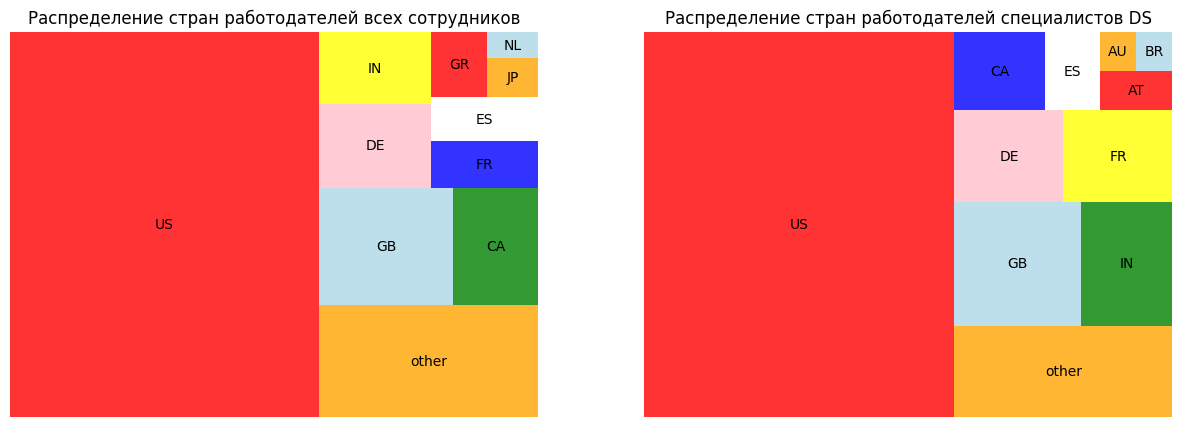

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# строим древовидную диаграмму с рапределением стран работодателей всех сотрудников
squarify.plot(
              sizes = data_cl.values, 
              label = data_cl.index, 
              alpha=.8, 
              color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'], 
              ax = axes[0]
              )
axes[0].set_title('Распределение стран работодателей всех сотрудников')
axes[0].axis('off')

# строим древовидную диаграмму с рапределением стран работодателей специалистов DS
squarify.plot(
              sizes = data_sc_cl.values, 
              label = data_sc_cl.index, 
              alpha=.8, 
              color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'],
              ax = axes[1]
              )
axes[1].set_title('Распределение стран работодателей специалистов DS')
axes[1].axis('off')

Большинство работодателей находятся в США. Это, как и страну проживания сотрудников, можно связать с Кремниевой Долиной. Так же, как и в ситуации с наиболее популярными странами проживания сотрудников, наиболее популярными странами работодателей являются Великобритания, Канада, Франция, Германия, Индия, Испания. 

Не смотря на то, что более половины сотрудников выполняют свою работу удаленно, судя по всему, территориально они находятся в тех же странах, что и работодатель. Это в первую очередь, связано с удобством взаимодействия, языком, отсутствием законодательных преград для работы, которые могут быть у иностранцев.

#### Распределение заработной платы в зависимости от страны работодателя.

In [200]:
# Преобразуем данные о странах проживания сотрудников и их количестве. Оставляем 10 наиболее популярных стран, остальные объединяем в "other", сортируем по убыванию средней зп
data_cl_sns = data.copy()
popular_location_sns = data_cl_sns['company_location'].value_counts().nlargest(10).index
data_cl_sns['company_location_new'] = data_cl_sns['company_location'].apply(lambda x: x if x in popular_location_sns else 'other')
data_cl_sns_new = pd.DataFrame(data_cl_sns.groupby('company_location_new')['salary_in_usd'].mean().sort_values(ascending = False))

In [201]:
# Преобразуем данные о странах проживания специалистов DS и их количестве. Оставляем 8 наиболее популярных стран, остальные объединяем в "other"
data_sc_cl_sns = data_sc.copy()
popular_location_sc_sns = data_sc_cl_sns['company_location'].value_counts().nlargest(8).index
data_sc_cl_sns['company_location_new'] = data_sc_cl_sns['company_location'].apply(lambda x: x if x in popular_location_sc_sns else 'other')
data_sc_cl_sns_new = pd.DataFrame(data_sc_cl_sns.groupby('company_location_new')['salary_in_usd'].mean().sort_values(ascending = False))

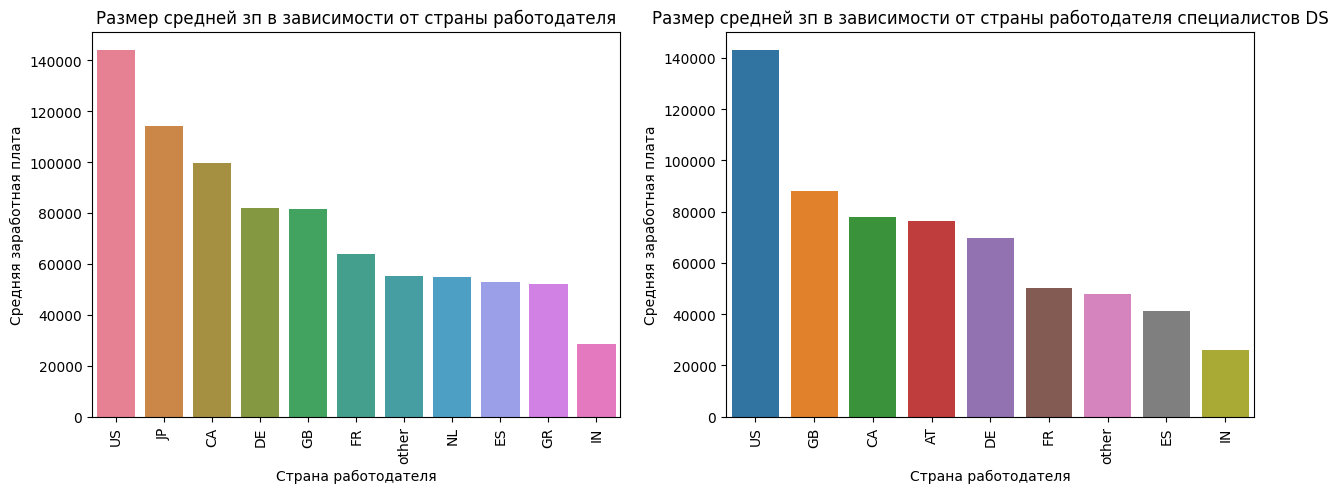

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от страны работодателя
sns.barplot(
            data_cl_sns_new, 
            x='company_location_new', 
            y='salary_in_usd', 
            hue='company_location_new',
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Страна работодателя', ylabel='Средняя заработная плата')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Размер средней зп в зависимости от страны работодателя')

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от страны работодателя специалистов DS
sns.barplot(
            data_sc_cl_sns_new, 
            x='company_location_new', 
            y='salary_in_usd', 
            hue='company_location_new',
            legend=False, 
            ax=axes[1]
            )
axes[1].set(xlabel='Страна работодателя', ylabel='Средняя заработная плата')
axes[1].xaxis.set_tick_params(rotation = 90)
axes[1].set_title('Размер средней зп в зависимости от страны работодателя специалистов DS')

plt.show()

In [203]:
salary_data_cl_sns = data_cl_sns.groupby('company_location_new')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от страны работодателя')
salary_data_cl_sns

Заработная плата в зависимости от страны работодателя


,count,mean,std,min,25%,50%,75%,max
company_location_new,,,,,,,,
CA,30.0,99823.73,46329.10,52000.0,69730.00,81895.5,117916.25,225000.0
DE,28.0,81887.21,39195.88,15966.0,58986.00,78015.0,90734.00,173762.0
ES,14.0,53060.14,21090.92,10354.0,40073.50,48371.5,68793.00,87932.0
FR,15.0,63970.67,28679.63,36643.0,48202.50,56738.0,69143.00,152000.0
GB,47.0,81583.04,29524.01,37300.0,57575.00,78526.0,103931.00,183228.0
GR,11.0,52293.09,19332.69,20000.0,42077.50,49461.0,60453.00,87932.0
IN,24.0,28581.75,22697.67,5409.0,16735.00,22124.0,32163.25,94665.0
JP,6.0,114127.33,83584.64,41689.0,66283.25,75682.0,145341.00,260000.0
NL,4.0,54945.75,13381.03,42000.0,44543.25,54021.0,64423.50,69741.0


In [204]:
salary_data_sc_cl_sns = data_sc_cl_sns.groupby('company_location_new')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от страны работодателя сотрудников DS')
salary_data_sc_cl_sns

Заработная плата в зависимости от страны работодателя сотрудников DS


,count,mean,std,min,25%,50%,75%,max
company_location_new,,,,,,,,
AT,2.0,76352.00,21050.57,61467.0,68909.50,76352.0,83794.50,91237.0
CA,5.0,77787.00,19301.65,52396.0,69336.00,75774.0,87738.00,103691.0
DE,7.0,69640.14,25045.56,25532.0,55997.00,79833.0,89694.00,90734.0
ES,3.0,41136.67,4935.34,37825.0,38300.50,38776.0,42792.50,46809.0
FR,7.0,50085.57,13658.91,36643.0,41056.50,49646.0,52256.50,77684.0
GB,11.0,88177.36,41393.50,39263.0,60847.00,76958.0,110808.00,183228.0
IN,8.0,26108.25,10248.05,9466.0,18057.50,29075.0,32163.25,40481.0
US,84.0,143115.68,56252.98,5679.0,105000.00,140000.0,167750.00,412000.0
other,16.0,47949.81,39413.93,2859.0,18478.25,37867.5,68720.25,122346.0


Размер заработной платы зависит от страны работодателя. 

Работодатели США предлагают своим сотрудникам наиболее высокую заработную плату. При чем у специалистов DS разница между заработной платой у работодателя из США и другими существенна (по многим параметрам в два и более раз). 

Работодатели из Индии предлагают самую низкую заработную плату. Это, может быть связано, с более низким уровнем жизни в Индии и более низкими заработными платами там во всех сферах.

#### Распределение компаний по размеру (количеству сотрудников)

In [205]:
# Получаем объект Series с распределением компаний по размеру (количеству сотрудников)
data_csize = data['company_size'].value_counts()

In [206]:
# Получаем объект Series с распределением компаний по размеру (количеству сотрудников) для специалистов DS
data_cs_csize = data_sc['company_size'].value_counts()

Text(0.5, 1.0, 'Распределение компаний по размеру, \n (количеству сотрудников) среди специалистов DS')

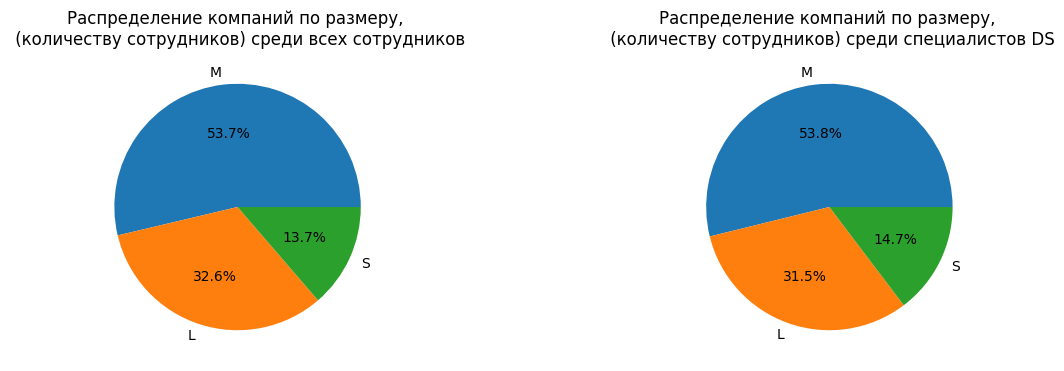

In [207]:
# Строим курговые диаграммы с рапределением компаний по размеру (количеству сотрудников) среди всех сотрудников и специалистов Data Scientist
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,4))
axes[0].pie(data_csize, labels = data_csize.index, autopct = '%.1f%%')
axes[0].set_title('Распределение компаний по размеру, \n (количеству сотрудников) среди всех сотрудников')
axes[1].pie(data_cs_csize, labels = data_cs_csize.index, autopct = '%.1f%%')
axes[1].set_title('Распределение компаний по размеру, \n (количеству сотрудников) среди специалистов DS')

Данные по размерам компаний сопоставимы между выборками для всех сотрудников и для специалистов DS. Больше половины в обеих занимают средние компании (М) с количеством сотрудников от 50 до 250.

Самой малочисленной является категория небольших компаний (S) с количесивом сотрудников менее 50. Это может быть связано с тем, что высокотехнологичные продукты подразумевают большее количество занятых людей, соответственно небольшим компаниям сложно развивать эту сферу деятельности.

#### Распределение заработной платы в зависимости от размера компании (количества сотрудников).

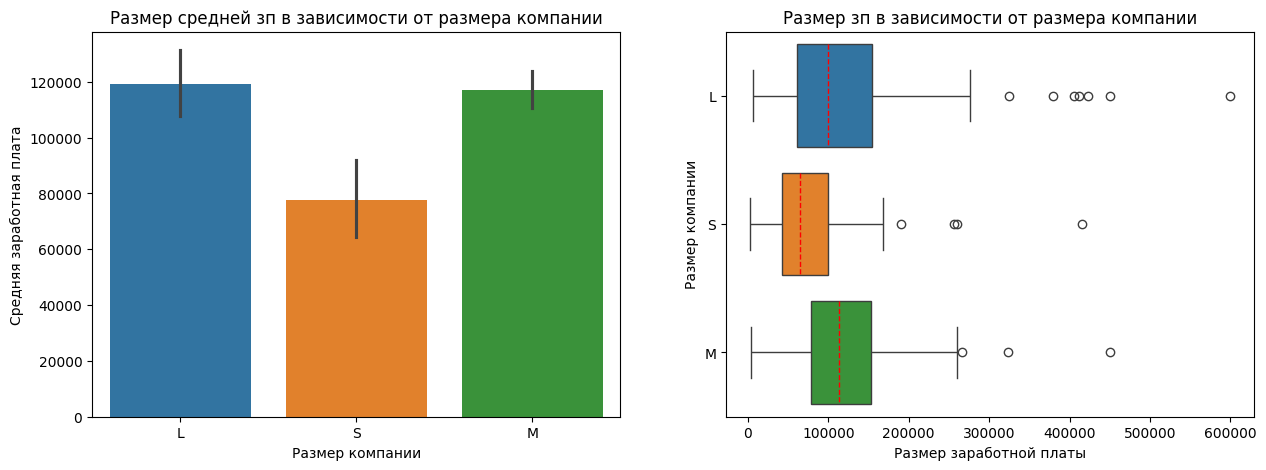

In [208]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от размера компании (количества сотрудников)
sns.barplot(
            data, 
            x='company_size', 
            y='salary_in_usd', 
            hue='company_size', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Размер компании', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней зп в зависимости от размера компании')

# Строим коробчатую диаграмму для визуализации размера заработной платы в зависимости от размера компании (количества сотрудников)
sns.boxplot(
            data, 
            x='salary_in_usd', 
            y='company_size', 
            orient='h', 
            hue='company_size',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Размер компании')
axes[1].set_title('Размер зп в зависимости от размера компании')

plt.show()

In [209]:
salary_csize = data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от размера компании')
salary_csize

Заработная плата в зависимости от размера компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,198.0,119242.99,86156.74,5882.0,61041.75,100000.0,154600.0,600000.0
M,326.0,116905.47,59287.69,4000.0,78131.50,113188.0,152875.0,450000.0
S,83.0,77632.67,63461.71,2859.0,41943.00,65000.0,100000.0,416000.0


Размер компании влияет на размер заработной платы. И если разница в показателях заработной платы у сотрудников средних и крупных компаний незначительна, но крупные компании предлагают все же чуть более высокую заработную плату. То небольшие компании не могут предложить своим сотрудникам сопоставимую с более крупными компаниями заработную плату.

#### Соотношение заработной платы у специалистов DS в зависимости от размера компании (количества сотрудников).

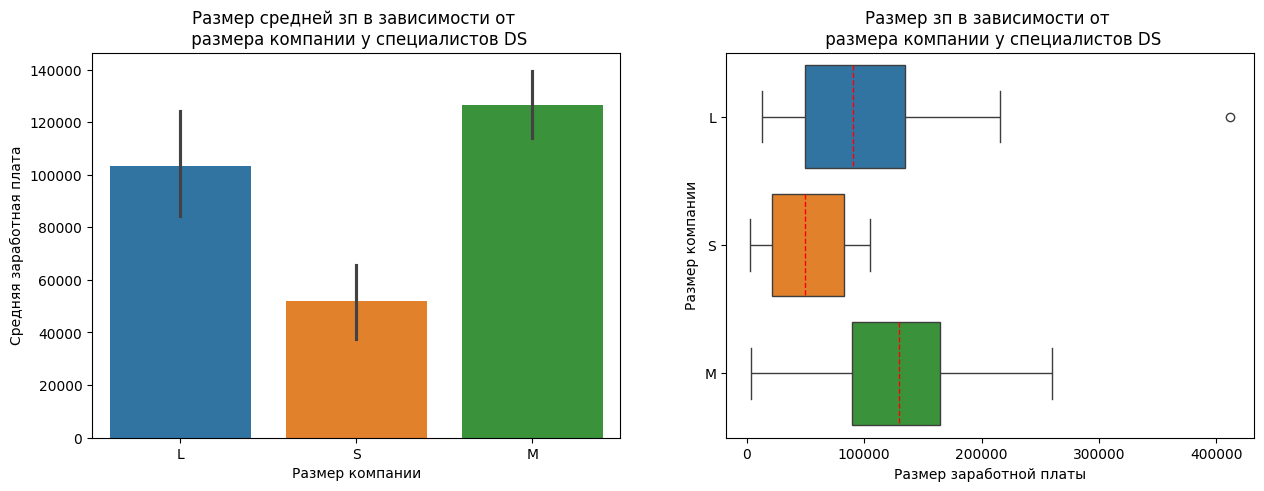

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы  в зависимости от размера компании (количества сотрудников) у специалистов DS
sns.barplot(
            data_sc, 
            x='company_size', 
            y='salary_in_usd', 
            hue='company_size', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Размер компании', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней зп в зависимости от \n размера компании у специалистов DS')

# Строим коробчатую диаграмму для визуализации размера заработной платы в зависимости от размера компании (количества сотрудников) у специалистов DS
sns.boxplot(
            data_sc, 
            x='salary_in_usd', 
            y='company_size', 
            orient='h', 
            hue='company_size',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Размер компании')
axes[1].set_title('Размер зп в зависимости от \n размера компании у специалистов DS')

plt.show()

In [211]:
salary_sc_csize = data_sc.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Заработная плата в зависимости от размера компании у специалистов DS')
salary_sc_csize

Заработная плата в зависимости от размера компании у специалистов DS


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


В выборке компаний для специалистов DS лидирующе место занимают средние компании, именно они предлагают наиболее выскоую заработную плату. Разница между показателями заработной платы различных категорий компаний для специалистов DS более существенна. Небольшие компании могут предложить специалистам заработную плату в 2 и более раз меньше, чем более крупные.

#### Корреляция признаков

In [212]:
data_cor = data.copy()

In [213]:
# кодируем некоторые категориальные признаки
ord_encoder = ce.OrdinalEncoder()
data_bin_el = ord_encoder.fit_transform(data_cor['experience_level'])
data_bin_et = ord_encoder.fit_transform(data_cor['employment_type'])
data_bin_cs = ord_encoder.fit_transform(data_cor['company_size'])
data_new = pd.concat([data_cor, data_bin_el, data_bin_et, data_bin_cs], axis=1)

Text(0.5, 1.0, 'Корреляция Спирмена')

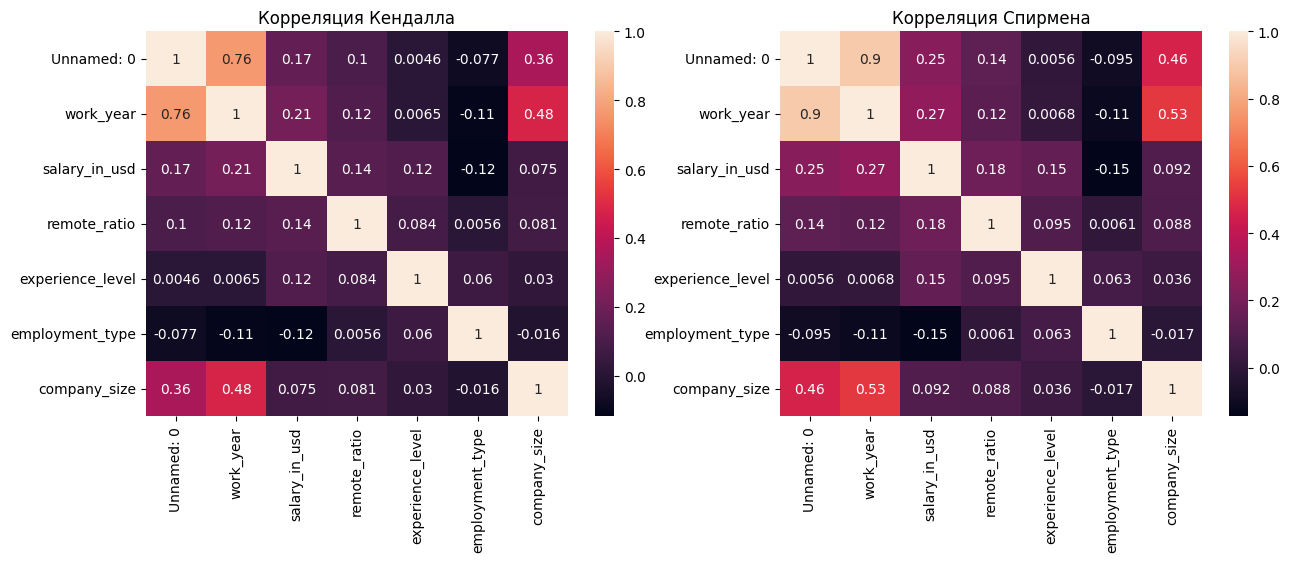

In [214]:
# строим тепловые карты корреляции
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(data_new.corr(method = 'kendall', numeric_only=True), annot = True, ax=axes[0])
axes[0].set_title('Корреляция Кендалла')
sns.heatmap(data_new.corr(method = 'spearman', numeric_only=True), annot = True, ax=axes[1])
axes[1].set_title('Корреляция Спирмена')

Согласно тепловой карте корреляция (Спирмена и Кенделла) между признаками находится в диапазоне от очень слабой до средней.

Предыдущий анализ данных показывал, что на заработную плату в той или иной мере влияют все, представленные в исследовании факторы. Однако, коэффициенты корреляции, говорят о том, что это влияние незначительно. Менее всего на заработную плату оказывает влияние размер компании, более всего размер заработной платы завсити от года, в котором она была выплачена.

### Статистический анализ данных

In [215]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


In [216]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в разные года одинаков.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в разные года неодинаков.

$$ H_1 : μ_1 != μ_2 != μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [217]:
# значения заработной платы
salary_ds_2020 = data_sc.loc[data_sc['work_year']==2020, 'salary_in_usd']
salary_ds_2021 = data_sc.loc[data_sc['work_year']==2021, 'salary_in_usd']
salary_ds_2022 = data_sc.loc[data_sc['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020')
result = stats.shapiro(salary_ds_2020)
decision_normality(result[1])

print('2021')
result = stats.shapiro(salary_ds_2021)
decision_normality(result[1])

print('2022')
result = stats.shapiro(salary_ds_2022)
decision_normality(result[1])


2020
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2022
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [218]:
# проводим тест
_, p = stats.kruskal(salary_ds_2020, salary_ds_2021, salary_ds_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер зарплат у специалистов Data Scientist в разные года различен.

Для ответа на поставленный бизнес-вопрос сравним попарно выборки по годам. 

1. 2020 и 2021
2. 2021 и 2022

### 2020 и 2021
1. Размер зарплат у специалистов Data Scientist в 2021 году больше, чем размер зарплат у специалистов Data Scientist в 2020 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в 2020 году ($μ_1$) больше или равен размеру зарплат у специалистов Data Scientist в 2021 году ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в 2020 году ($μ_1$) меньше зарплат у специалистов Data Scientist в 2021 году ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Два.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки гипотезы можно использовать U-критерий Манна-Уитни.

**Проведём тест**

In [219]:
# проводим тест
_, p = stats.mannwhitneyu(salary_ds_2020, salary_ds_2021, alternative='less')
decision_hypothesis(p)

p-value = 0.685
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утвреждать, что размер зарплат у специалистов Data Scientist в 2021 году больше, чем размер зарплат у специалистов Data Scientist в 2020 году.

### 2021 и 2022
2. Размер зарплат у специалистов Data Scientist в 2022 году больше, чем размер зарплат у специалистов Data Scientist в 2021 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в 2021 году ($μ_1$) больше или равен размеру зарплат у специалистов Data Scientist в 2022 году ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в 2021 году ($μ_1$) меньше зарплат у специалистов Data Scientist в 2022 году ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Два.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да. 

Для проверки гипотезы можно использовать двухвыборочный t-критерий.

**Проведём тест**

In [220]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_ds_2021, salary_ds_2022)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.445
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [221]:
# проводим тест на сравнение средних в группах
_, p = stats.ttest_ind(salary_ds_2021, salary_ds_2022, alternative='less', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер зарплат у специалистов Data Scientist в 2022 году больше, чем размер зарплат у специалистов Data Scientist в 2021 году.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты Data Scientist ($μ_1$) статистически больше либо равен размер зарплаты Data Engineer ($μ_2$) в 2022 году.

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты Data Scientist ($μ_1$) статистически меньше, чем размер зарплаты Data Engineer ($μ_2$) в 2022 году..

$$ H_1 : μ_1 < μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [222]:
# значения заработной платы
salary_sc_2022 = data_sc_en_2022.loc[data_sc_en_2022['job_title']=='Data Scientist', 'salary_in_usd']
salary_en_2022 = data_sc_en_2022.loc[data_sc_en_2022['job_title']=='Data Engineer', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Data Scientist:')
result = stats.shapiro(salary_sc_2022)
decision_normality(result[1])

print('Data Engineer:')
result = stats.shapiro(salary_en_2022)
decision_normality(result[1])

Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки гипотезы можно использовать U-критерий Манна-Уитни.

**Проведём тест**

In [223]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sc_2022, salary_en_2022, alternative='less')
decision_hypothesis(p)

p-value = 0.923
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утвреждать, что размер зарплат у специалистов Data Scientist в 2022 году меньше чем размер зарплат у специалистов Data Engineer.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в компаниях разного размера одинаков.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в компаниях разного размера неодинаков.

$$ H_1 : μ_1 != μ_2 != μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [224]:
# значения заработной платы
salary_sc_s = data_sc.loc[data_sc['company_size']=='S', 'salary_in_usd']
salary_sc_m = data_sc.loc[data_sc['company_size']=='M', 'salary_in_usd']
salary_sc_l = data_sc.loc[data_sc['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020')
result = stats.shapiro(salary_sc_s)
decision_normality(result[1])

print('2021')
result = stats.shapiro(salary_sc_m)
decision_normality(result[1])

print('2022')
result = stats.shapiro(salary_sc_l)
decision_normality(result[1])


2020
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2021
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2022
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [225]:
# проводим тест
_, p = stats.kruskal(salary_sc_s, salary_sc_m, salary_sc_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер зарплат у специалистов Data Scientist компаниях разного размера различен.

Соотнесем зарпаты специалистов Data Scientist в компаниях разного размера попарно. 

1. S и M
2. M и L
3. S и L

### S и M
1. Размер зарплат у специалистов Data Scientist в комапании размера S меньше, чем размер зарплат у специалистов Data Scientist в комапании размера M?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в комапании размера S ($μ_1$) меньше или равен размеру зарплат у специалистов Data Scientist в комапании размера M ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в комапании размера S ($μ_1$) больше зарплат у специалистов Data Scientist в комапании размера M ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да. 

Для проверки гипотезы можно использовать двухвыборочный t-критерий.

**Проведём тест**

In [226]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_sc_s, salary_sc_m)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.025
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.


In [227]:
# проводим тест на сравнение средних в группах
_, p = stats.ttest_ind(salary_sc_s, salary_sc_m, alternative='greater', equal_var=False)
decision_hypothesis(p)

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер зарплат у специалистов Data Scientist в комапании размера S больше зарплат у специалистов Data Scientist в комапании размера M

### M и L
2. Размер зарплат у специалистов Data Scientist в комапании размера M меньше, чем размер зарплат у специалистов Data Scientist в комапании размера L?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в комапании размера M ($μ_1$) меньше или равен размеру зарплат у специалистов Data Scientist в комапании размера L ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в комапании размера M ($μ_1$) больше зарплат у специалистов Data Scientist в комапании размера L ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки гипотезы можно использовать U-критерий Манна-Уитни.

**Проведём тест**

In [228]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sc_m, salary_sc_l, alternative='greater')
decision_hypothesis(p)


p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер зарплат у специалистов Data Scientist в комапании размера M больше зарплат у специалистов Data Scientist в комапании размера L

### S и L
3. Размер зарплат у специалистов Data Scientist в комапании размера S меньше, чем размер зарплат у специалистов Data Scientist в комапании размера L?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist в комапании размера S ($μ_1$) меньше или равен размеру зарплат у специалистов Data Scientist в комапании размера L ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist в комапании размера S ($μ_1$) больше зарплат у специалистов Data Scientist в комапании размера L ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки гипотезы можно использовать U-критерий Манна-Уитни.

**Проведём тест**

In [229]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sc_s, salary_sc_l, alternative='greater')
decision_hypothesis(p)

p-value = 0.999
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер зарплат у специалистов Data Scientist в комапании размера S больше зарплат у специалистов Data Scientist в комапании размера L

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): между наличием должностей Data Scientist, Data Engineer и размером компании нет взаимосвязи (признаки независимы)

*Альтернативная гипотеза* ($H_1$): между наличием должностей Data Scientist, Data Engineer и размером компании есть взаимосвязь (признаки взаимосвязаны)


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. 
* Какой тип у признака «company_size»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [230]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data_sc_en['job_title'], data_sc_en['company_size'])

cross_table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


In [231]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между наличием должностей Data Scientist, Data Engineer и размером компании.

### Дополнительное исследование.

### Как соотносится зарплата Data Scientist и средняя зарпалаты в отрасли IT в США в 2022 году?

Согласно аналитическим материалам средняя заработная плата в США в 2022 году в IT составляла 72553.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты Data Scientist ($μ_1$) статистически больше либо равен среднему размер зарплаты в отрасли IT в США ($μ_2$) в 2022 году.

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты Data Scientist ($μ_1$) статистически меньше, чем средний размер зарплаты в отрасли IT в США ($μ_2$) в 2022 году.

$$ H_1 : μ_1 < μ_2$$

**Визуальный анализ данных**

In [232]:
# значение заработной платы
data_sc_2022 = data_sc[data_sc['work_year']==2022]
data_sc_2022_usa = data_sc_2022[data_sc_2022['company_location']=='US']

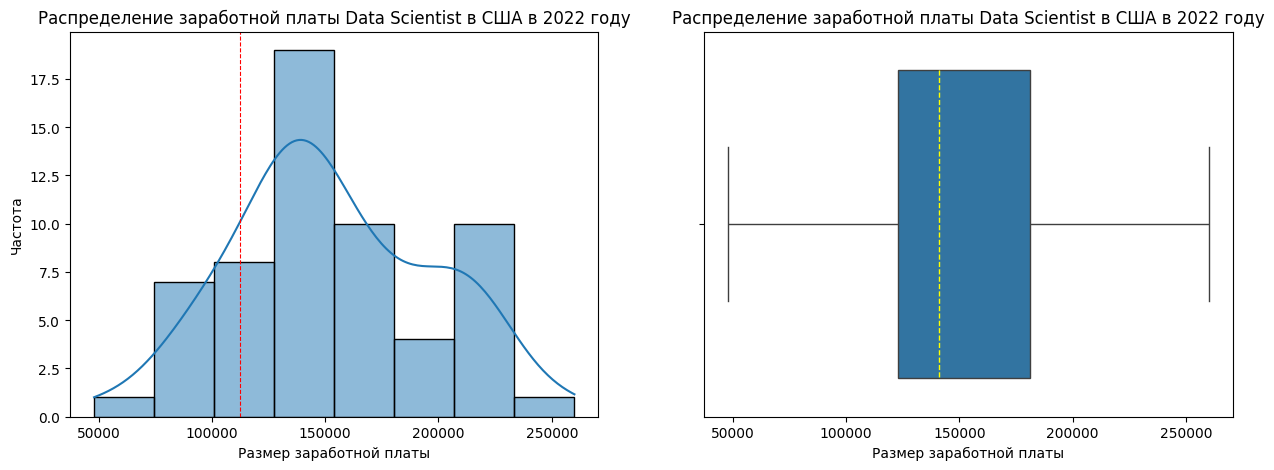

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим гистограмму, показывающую распределение заработной платы Data Scientist в США в 2022 году
sns.histplot(data_sc_2022_usa['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы', ylabel='Частота')
axes[0].set_title('Распределение заработной платы Data Scientist в США в 2022 году')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

# Строим коробчатую, показывающую распределение заработной платы
sns.boxplot(data_sc_2022_usa['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "yellow", "linestyle": '--'})
axes[1].set(xlabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы Data Scientist в США в 2022 году')

plt.show()

In [234]:
salary_2022_usa = data_sc_2022_usa['salary_in_usd'].describe().round(2)
print('Заработная плата среди специалистов Data Scientist в США в 2022')
salary_2022_usa

Заработная плата среди специалистов Data Scientist в США в 2022


count        60.00
mean     153483.33
std       44432.70
min       48000.00
25%      123000.00
50%      140850.00
75%      181275.00
max      260000.00
Name: salary_in_usd, dtype: float64

Распределение заработной платы похоже на нормальное.

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [235]:
# значения заработной платы
salary_sc_2022_usa = data_sc_2022.loc[data_sc_2022['company_location']=='US', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Data Scientist_2022_USA:')
result = stats.shapiro(salary_sc_2022_usa)
decision_normality(result[1])

Data Scientist_2022_USA:
p-value = 0.243
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Да. 

Для проверки гипотезы можно использовать одновыборочный t-критерий.

**Проведём тест**

In [236]:
_, p = stats.ttest_1samp(salary_sc_2022_usa, popmean=72553, alternative='less')
decision_hypothesis(p)

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер заработной платы Data Scientist в США в 2022 году меньше, чем средний размер зарплаты в отрасли IT в США.

### Зарплата специалистов Data Scientist, работающих удаленно больше, чем зарплата специалистов Data Scientist, у которых нет удаленной работы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты Data Scientist, работающих удаленно ($μ_1$) статистически больше либо равен размеру зарплаты специалистов Data Scientist, у которых нет удаленной работы ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты Data Scientist, работающих удаленно ($μ_1$) статистически меньше, чем размер зарплаты специалистов Data Scientist, у которых нет удаленной работы( $μ_2$).

$$ H_1 : μ_1 < μ_2$$

In [237]:
# фильтруем данные по объему выполняемой работы и создаем датасет с отфильтрованными данными для построения визуализаций 
data_sc_r0 =data_sc[data_sc['remote_ratio'] == 0]
data_sc_r100 =data_sc[data_sc['remote_ratio'] == 100]
data_sc_rr = pd.concat([data_sc_r0, data_sc_r100], ignore_index = True)

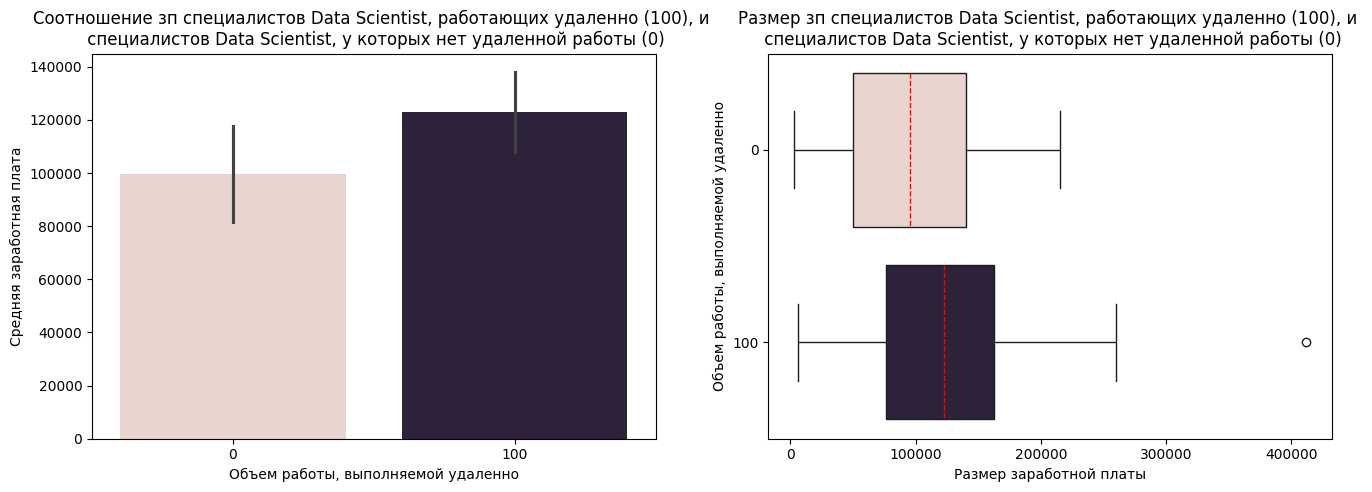

In [238]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы в зависимости от объема работы, выполняемой удаленно, у специалистов DS
sns.barplot(
            data_sc_rr, 
            x='remote_ratio', 
            y='salary_in_usd', 
            hue='remote_ratio', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Объем работы, выполняемой удаленно', ylabel='Средняя заработная плата')
axes[0].set_title('Соотношение зп специалистов Data Scientist, работающих удаленно (100), и \n специалистов Data Scientist, у которых нет удаленной работы (0)')

# Строим коробчатую диаграмму для визуализации размера заработной платы в зависимости от объема работы, выполняемой удаленно, у специалистов DS
sns.boxplot(
            data_sc_rr, 
            x='salary_in_usd', 
            y='remote_ratio', 
            orient='h', 
            hue='remote_ratio',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Объем работы, выполняемой удаленно')
axes[1].set_title('Размер зп специалистов Data Scientist, работающих удаленно (100), и \n специалистов Data Scientist, у которых нет удаленной работы (0)')

plt.show()

In [239]:
salary_sc_rr1 = data_sc_rr.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Заработная плата специалистов Data Scientist, работающих удаленно, \n и специалистов Data Scientist, у которых нет удаленной работы')
salary_sc_rr1

Заработная плата специалистов Data Scientist, работающих удаленно, 
 и специалистов Data Scientist, у которых нет удаленной работы


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.74,58259.42,2859.0,50294.5,95550.0,140400.0,215300.0
100,79.0,123125.94,69370.99,5679.0,76366.0,123000.0,162500.0,412000.0


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. 

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [240]:
# значения заработной платы
salary_sc_0 = data_sc.loc[data_sc['remote_ratio'] == 0, 'salary_in_usd']
salary_sc_100 = data_sc.loc[data_sc['remote_ratio'] == 100, 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Data Scientist:')
result = stats.shapiro(salary_sc_0)
decision_normality(result[1])

print('Data Engineer:')
result = stats.shapiro(salary_sc_100)
decision_normality(result[1])

Data Scientist:
p-value = 0.363
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Data Engineer:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки гипотезы можно использовать U-критерий Манна-Уитни.

**Проведём тест**

In [241]:
# проводим тест
_, p = stats.mannwhitneyu(salary_sc_2022, salary_en_2022, alternative='less')
decision_hypothesis(p)

p-value = 0.923
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер зарплат зарплаты у специалистов Data Scientist, у которых нет удаленной работы больше, чем у специалистов Data Scientist работающих удаленно.

## Итоговые результаты исследования

*   Размер зарплат у специалистов Data Scientist в разные года различен. Нет оснований утвреждать, что размер зарплат у специалистов Data Scientist в 2021 году больше, чем размер зарплат у специалистов Data Scientist в 2020 году. Размер зарплат у специалистов Data Scientist в 2022 году больше, чем размер зарплат у специалистов Data Scientist в 2021 году.
*   Нет оснований утвреждать, что размер зарплат у специалистов Data Scientist в 2022 году меньше чем размер зарплат у специалистов Data Engineer.
*   Размер зарплат у специалистов Data Scientist компаниях разного размера различен. Нет оснований утверждать, что размер зарплат у специалистов Data Scientist в комапании размера S больше зарплат у специалистов Data Scientist в комапании размера M. Размер зарплат у специалистов Data Scientist в комапании размера M больше зарплат у специалистов Data Scientist в комапании размера L. Нет оснований утверждать, что размер зарплат у специалистов Data Scientist в комапании размера S больше зарплат у специалистов Data Scientist в комапании размера L.
*   Существует статистически значимая взаимосвязь между наличием должностей Data Scientist, Data Engineer и размером компании.
*   Нет оснований утверждать, что размер заработной платы Data Scientist в США в 2022 году меньше, чем средний размер зарплаты в отрасли IT в США.
*   Нет оснований утверждать, что размер зарплат зарплаты у специалистов Data Scientist, у которых нет удаленной работы больше, чем у специалистов Data Scientist работающих удаленно.